# Airbnb dataset

![](https://www.digital.ink/wp-content/uploads/airbnb_logo_detail.jpg)

### Description:
In this project, the popularity of an Airbnb posting is being measured using the 'reviews_per_month' variable as a proxy, although it's important to note that this may not be the most accurate measure as not all guests may leave a review after their stay. Nonetheless, this is being treated as a fun project and the approach is considered valid. The project involves testing and evaluating two models: a simple Linear Regression model, which will be used as a baseline for future models, and a tree boosting based model (XGB)

In [36]:
import numpy as np 
import pandas as pd
import seaborn as sns
import xgboost as xgb
import random
import json
import os
import functools
import re
import eli5
import requests
import nltk
nltk.data.path.append('/path/to/nltk_data')

from matplotlib import pyplot as plt
from geopy.distance import geodesic 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_validate, KFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, normalize, scale
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from nltk.corpus import stopwords

from plotly import express as px
import plotly.io as pio
from plotly import graph_objects as go


In [2]:
#Render config for mapbox
pio.renderers
pio.renderers.default = "notebook_connected"

In [3]:
#mapbox token
my_mapbox_token = "sk.eyJ1IjoiY3lyaW5lMTQwOSIsImEiOiJjbGdiOXZvM3AwbGN0M2NxbGc1cGh6OWFoIn0.a3JoVv6dEn1TJmh9rp3jOw" # Replace with your actual Mapbox token

px.set_mapbox_access_token(my_mapbox_token)

## Data Understanding

In [4]:
db = pd.read_csv('Airbnb_NYC.csv')

In [5]:
db.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [6]:
db_subs = db[['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365']]
db_subs.head(10)

id                                              name  host_id   
0  2539                Clean & quiet apt home by the park     2787  \
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
5  5099         Large Cozy 1 BR Apartment In Midtown East     7322   
6  5121                                   BlissArtsSpace!     7356   
7  5178                  Large Furnished Room Near B'way      8967   
8  5203                Cozy Clean Guest Room - Family Apt     7490   
9  5238                Cute & Cozy Lower East Side 1 bdrm     7549   

     host_name neighbourhood_group       neighbourhood  latitude  longitude   
0         John            Brooklyn          Kensington  40.64749  -73.97237  \
1     Jennifer           Manhattan             Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan              Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn        Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan         East Harlem  40.79851  -73.94399   
5        Chris           Manhattan         Murray Hill  40.74767  -73.97500   
6        Garon            Brooklyn  Bedford-Stuyvesant  40.68688  -73.95596   
7     Shunichi           Manhattan      Hell's Kitchen  40.76489  -73.98493   
8    MaryEllen           Manhattan     Upper West Side  40.80178  -73.96723   
9          Ben           Manhattan           Chinatown  40.71344  -73.99037   

         room_type  price  minimum_nights  number_of_reviews last_review   
0     Private room    149               1                  9  2018-10-19  \
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   
5  Entire home/apt    200               3                 74  2019-06-22   
6     Private room     60              45                 49  2017-10-05   
7     Private room     79               2                430  2019-06-24   
8     Private room     79               2                118  2017-07-21   
9  Entire home/apt    150               1                160  2019-06-09   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0  
5               0.59                               1               129  
6               0.40                               1                 0  
7               3.47                               1               220  
8               0.99                               1                 0  
9               1.33                               4               188

In [7]:
print(f"Number of data rows: {db_subs.count()[0]}")

Number of data rows: 48895


In [8]:
db_subs.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [9]:
db_subs.describe()

id       host_id      latitude     longitude         price   
count  4.889500e+04  4.889500e+04  48895.000000  48895.000000  48895.000000  \
mean   1.901714e+07  6.762001e+07     40.728949    -73.952170    152.720687   
std    1.098311e+07  7.861097e+07      0.054530      0.046157    240.154170   
min    2.539000e+03  2.438000e+03     40.499790    -74.244420      0.000000   
25%    9.471945e+06  7.822033e+06     40.690100    -73.983070     69.000000   
50%    1.967728e+07  3.079382e+07     40.723070    -73.955680    106.000000   
75%    2.915218e+07  1.074344e+08     40.763115    -73.936275    175.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990  10000.000000   

       minimum_nights  number_of_reviews  reviews_per_month   
count    48895.000000       48895.000000       38843.000000  \
mean         7.029962          23.274466           1.373221   
std         20.510550          44.550582           1.680442   
min          1.000000           0.000000           0.010000   
25%          1.000000           1.000000           0.190000   
50%          3.000000           5.000000           0.720000   
75%          5.000000          24.000000           2.020000   
max       1250.000000         629.000000          58.500000   

       calculated_host_listings_count  availability_365  
count                    48895.000000      48895.000000  
mean                         7.143982        112.781327  
std                         32.952519        131.622289  
min                          1.000000          0.000000  
25%                          1.000000          0.000000  
50%                          1.000000         45.000000  
75%                          2.000000        227.000000  
max                        327.000000        365.000000

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'host_id'}>,
        <Axes: title={'center': 'latitude'}>],
       [<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'minimum_nights'}>],
       [<Axes: title={'center': 'number_of_reviews'}>,
        <Axes: title={'center': 'reviews_per_month'}>,
        <Axes: title={'center': 'calculated_host_listings_count'}>],
       [<Axes: title={'center': 'availability_365'}>, <Axes: >, <Axes: >]],
      dtype=object)

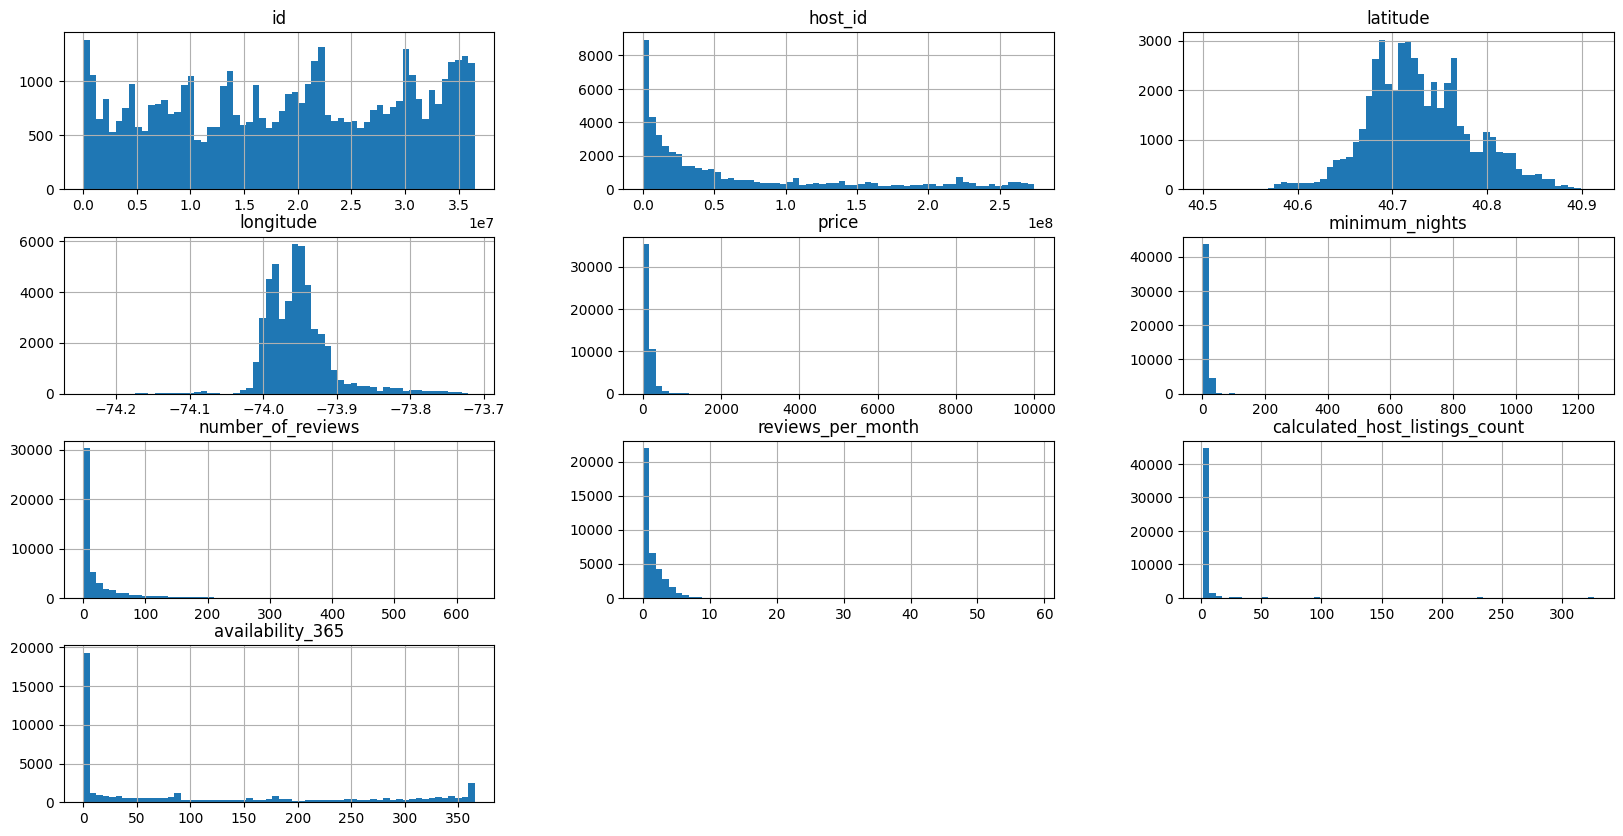

In [10]:
#viewing data histograms
db_subs.hist(bins=60, figsize=(20,10))

## Data Analysis & Cleaning

        Prices Analysis

C:\Users\DELL\AppData\Local\Temp\ipykernel_13348\1417624290.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\DELL\AppData\Local\Temp\ipykernel_13348\1417624290.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\DELL\AppData\Local\Temp\ipykernel_13348\1417624290.py:12: UserWarning:

Matplotlib is cur

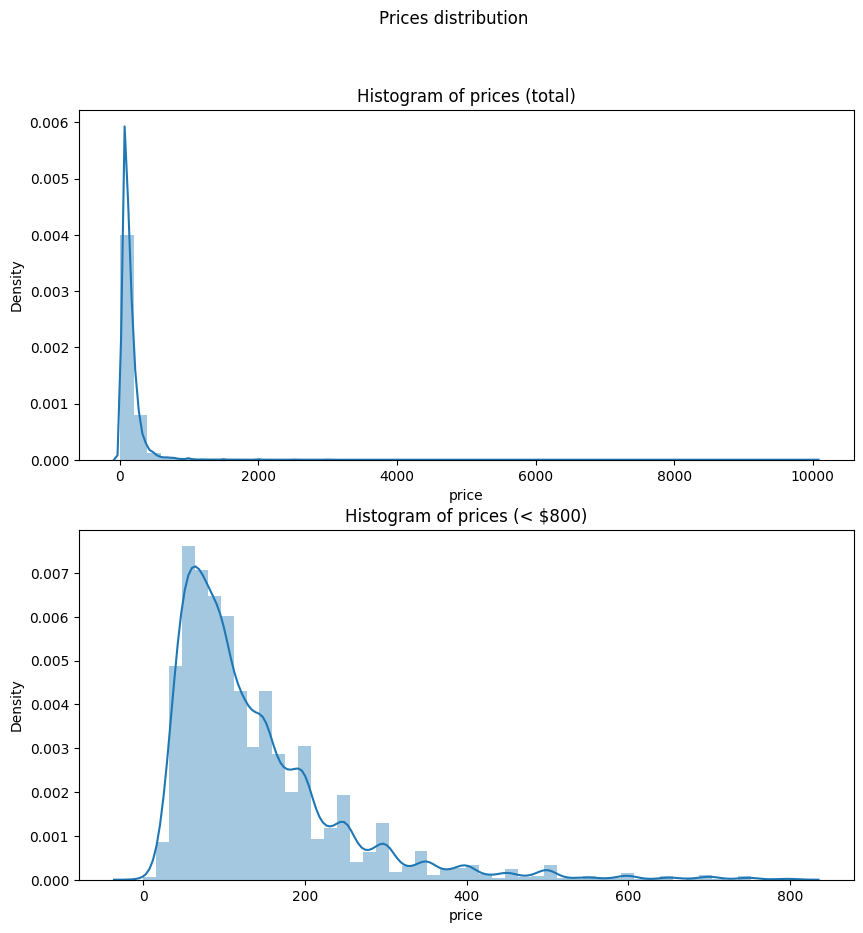

In [11]:
#Distribution
fig, ax= plt.subplots(2,1, figsize=(10,10))

ax[0].set_title("Histogram of prices (total)")
sns.distplot(db_subs['price'], kde=True, ax=ax[0])
ax[1].set_title("Histogram of prices (< $800)")
sns.distplot(db_subs[db_subs['price'] < 800]['price'], kde=True, ax=ax[1])



fig.suptitle("Prices distribution")
fig.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_13348\2434754744.py:13: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



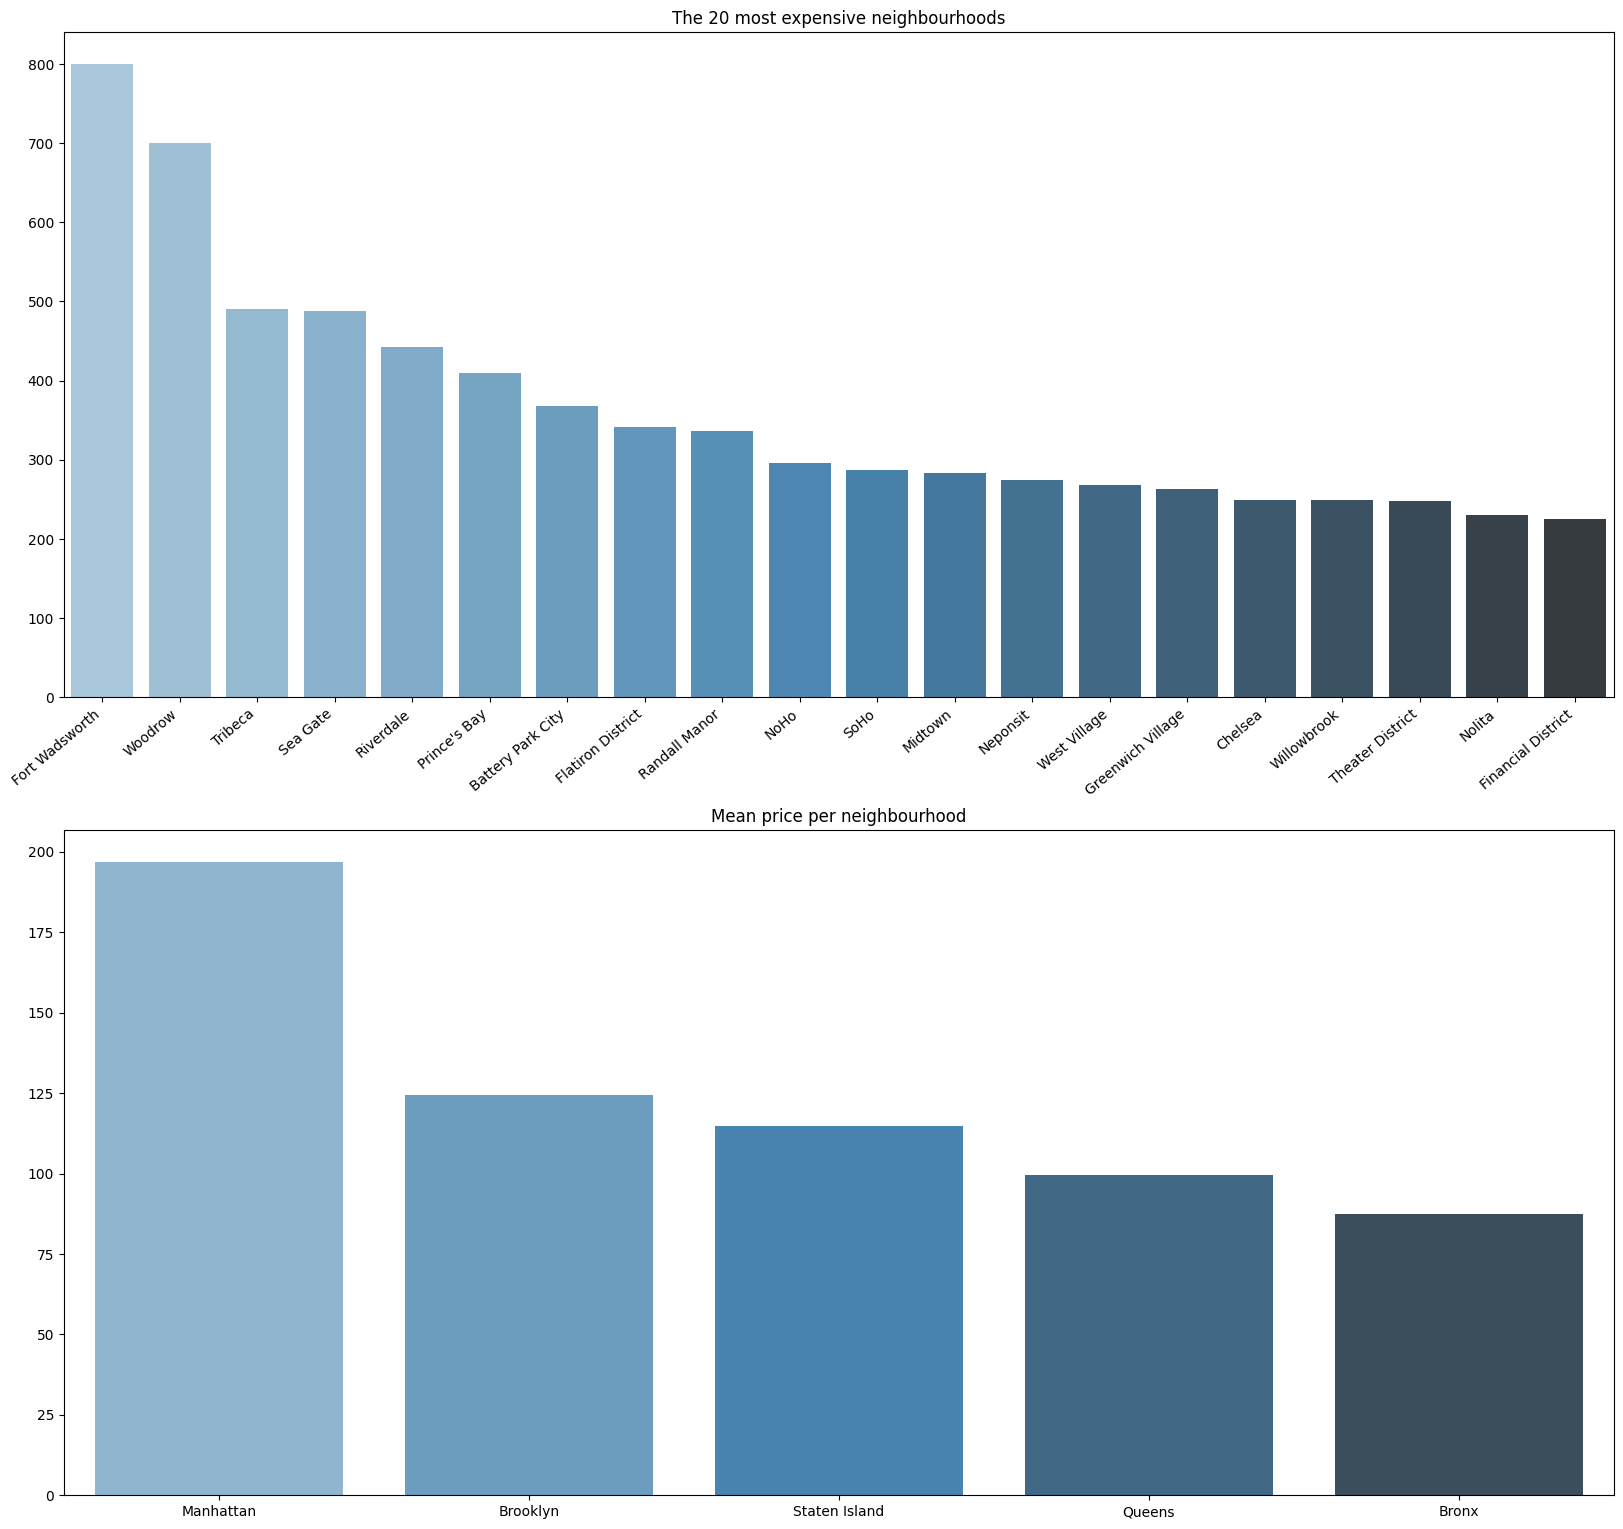

In [12]:
#Most expensive zones (spatial distriution)
d = db_subs.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)

fig, ax= plt.subplots(2,1, figsize=(20,19))
sns.barplot(x=d.index.tolist()[:20], y=d.values[:20], ax=ax[0], palette=("Blues_d"))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title('The 20 most expensive neighbourhoods')

d = db_subs.groupby('neighbourhood_group')['price'].mean().sort_values(ascending=False)[:5]
sns.barplot(x=d.index.tolist(), y=d.values, ax=ax[1], palette=("Blues_d"))
ax[1].set_title('Mean price per neighbourhood')

fig.show()

-> The price distribution here shows that most of the prices are under $700

Visualizing the same results but on a map this time

In [13]:
# a list of lists containing color values and their corresponding
# positions on a gradient scale. The first item in each sublist is a 
# float value between 0 and 1 representing the position of the color 
# on the gradient scale, while the second item is a string representing 
# the color in RGB format from red to purple 
cscale = [
          [0.0, 'rgb(165,0,38)'], 
          [0.0005, 'rgb(215,48,39)'], 
          [0.007, 'rgb(250, 152, 122)'], 
          [0.08, 'rgb(208, 254, 144)'], 
          [0.1, 'rgb(0, 255, 179)'], 
          [0.3, 'rgb(171,217,233)'], 
          [0.7, 'rgb(116,173,209)'], 
          [0.9, 'rgb(69,117,180)'], 
          [1.0, 'rgb(49,54,149)']
         ]

The colors grading is going to be done according to the pricing

In [14]:
#plotting according to price distribution results
fig = px.scatter_mapbox(db_subs,
                        lat=db_subs['latitude'], 
                        lon=db_subs['longitude'],  
                        zoom=10,
                        color=db_subs['price'], 
                        color_continuous_scale=cscale, 
                        size_max=20, height=760,
                        title='Map of NYC cheap Airbnb rooms (price<=$700)', 
                        range_color=(0,700))
#fig.show(renderer='vscode')
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":10})
fig.show()


In [15]:
fig = px.scatter_mapbox(db_subs[db_subs['price'] > 700], 
                        lat=db_subs['latitude'], 
                        lon=db_subs['longitude'],  
                        color=db_subs['price'], 
                        color_continuous_scale=cscale,     
                        height=760,
                        size_max=20, 
                        zoom=10, 
                        title='Scatter map NYC most expensive Airbnb rooms (price>$700)')

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":10})
fig.show()

Prices based on room types

C:\Users\DELL\AppData\Local\Temp\ipykernel_13348\2162500111.py:5: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



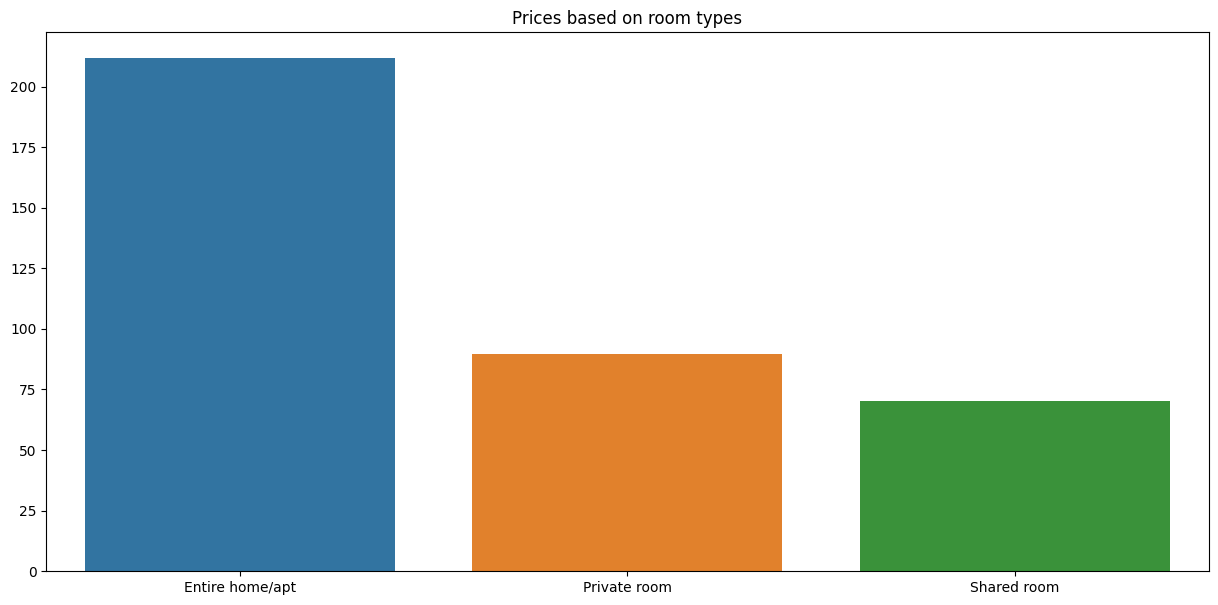

In [16]:
d = db_subs.groupby('room_type')['price'].mean().sort_values(ascending=False)
fig, ax= plt.subplots(figsize=(15,7))
sns.barplot(x=d.index.tolist(), y=d.values, ax=ax)
ax.set_title('Prices based on room types')
fig.show()

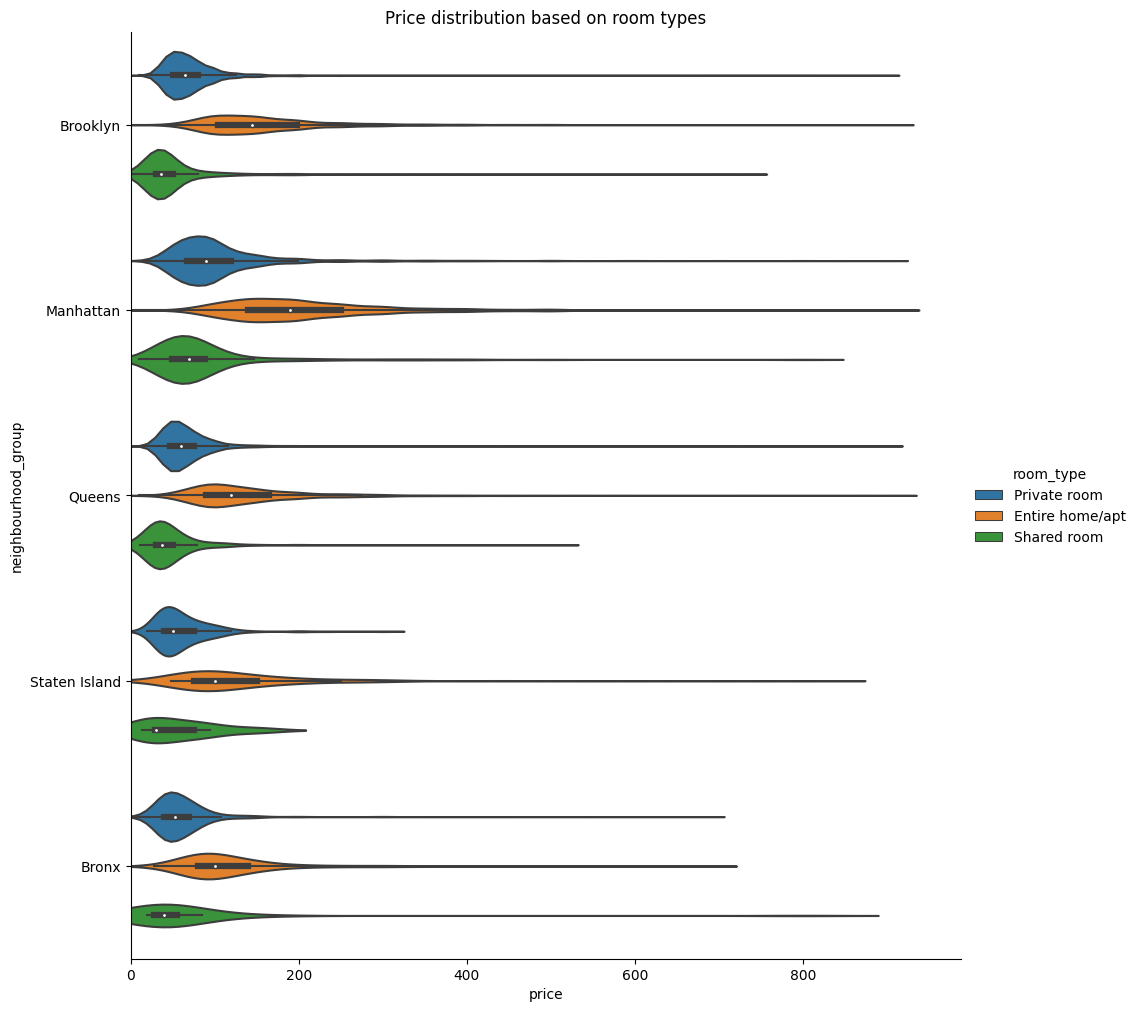

In [17]:
f = sns.catplot(x="price", y="neighbourhood_group", hue="room_type", data=db_subs[db_subs['price'] <= 900], kind='violin', height=10)
f.axes[0][0].set_xlim(0,)
plt.title('Price distribution based on room types')
plt.show()

In [18]:
fig = px.scatter_mapbox(db_subs[db_subs['price'] <= 700], 
                        lat=db_subs['latitude'], 
                        lon=db_subs['longitude'], 
                        zoom=10, 
                        color=db_subs['room_type'], 
                        size=db_subs['price'],
                        color_continuous_scale=cscale, 
                        height=760,
                        size_max=20, 
                        title='Room type distribution')

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":10})
fig.show()

Prices based on the popularity of the rooms

In [19]:
px.scatter(db_subs[db_subs['price']<700], x="reviews_per_month", y='price', color='room_type')

Price trends

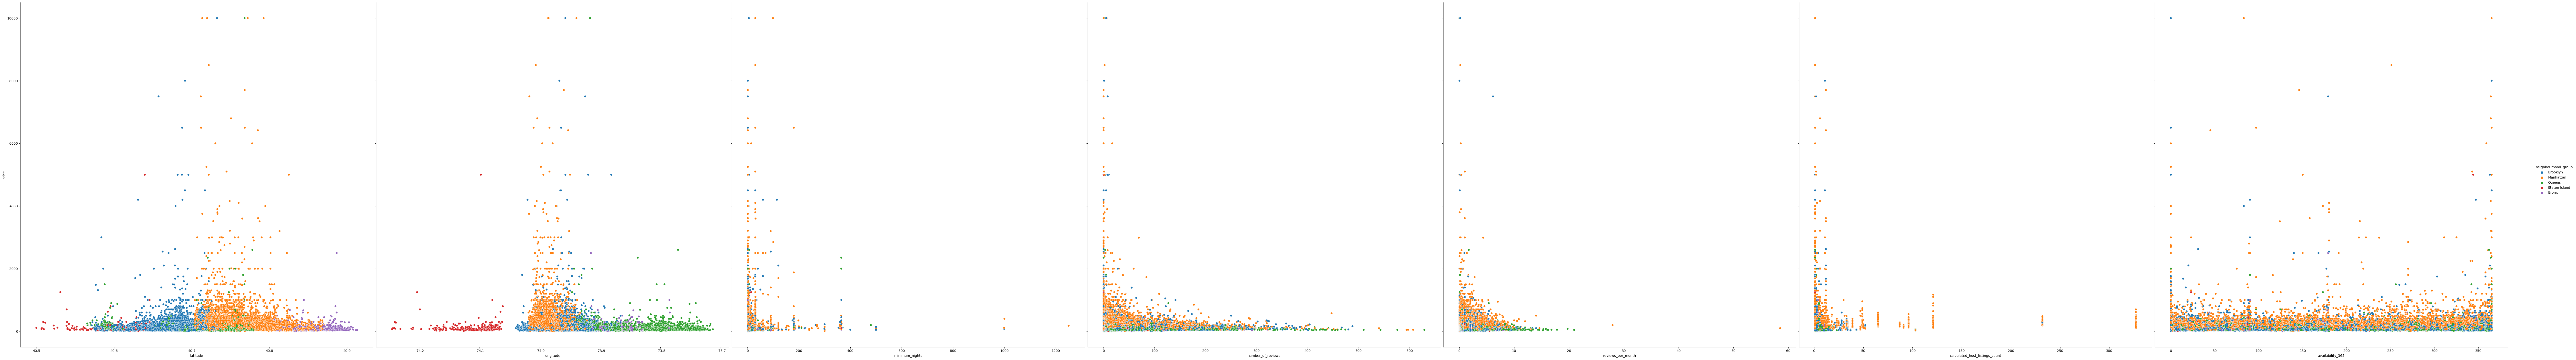

In [20]:
sns.pairplot(db_subs, y_vars=['price'], 
x_vars=['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365'], 
height=15, 
hue='neighbourhood_group')

=> Conclusions:

-The cost of renting an entire apartment is generally higher compared to other types of accommodations. Shared rooms, on the other hand, are more commonly found in the city center. 
-Despite similar price distributions of each room type across the five different zones in New York, their mean prices differ. 
-Private and shared rooms tend to have similar prices, with less variability, while entire apartments are more expensive and variable, likely due to other factors such as square footage or proximity to public transportation. 
-Analysis of the Popularity/Price plot reveals that rooms with more reviews tend to be cheaper, although this pattern is more erratic for entire apartments. This suggests that a predictive model that incorporates popularity as a factor could be useful for estimating room prices. 
-Furthermore, staying in a room for 14 to 28 nights is generally more economical, and most accommodations require a minimum stay of around two nights.



        Posting Analysis

In [21]:
host_listings_count = db_subs.groupby('host_id')['calculated_host_listings_count'].mean()

In [22]:
summary = host_listings_count.describe()
summary

count    37457.000000
mean         1.305363
std          2.760747
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        327.000000
Name: calculated_host_listings_count, dtype: float64

C:\Users\DELL\AppData\Local\Temp\ipykernel_13348\2085177788.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\DELL\AppData\Local\Temp\ipykernel_13348\2085177788.py:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\DELL\AppData\Local\Temp\ipykernel_13348\2085177788.py:6: UserWarning:

Matplotlib is curr

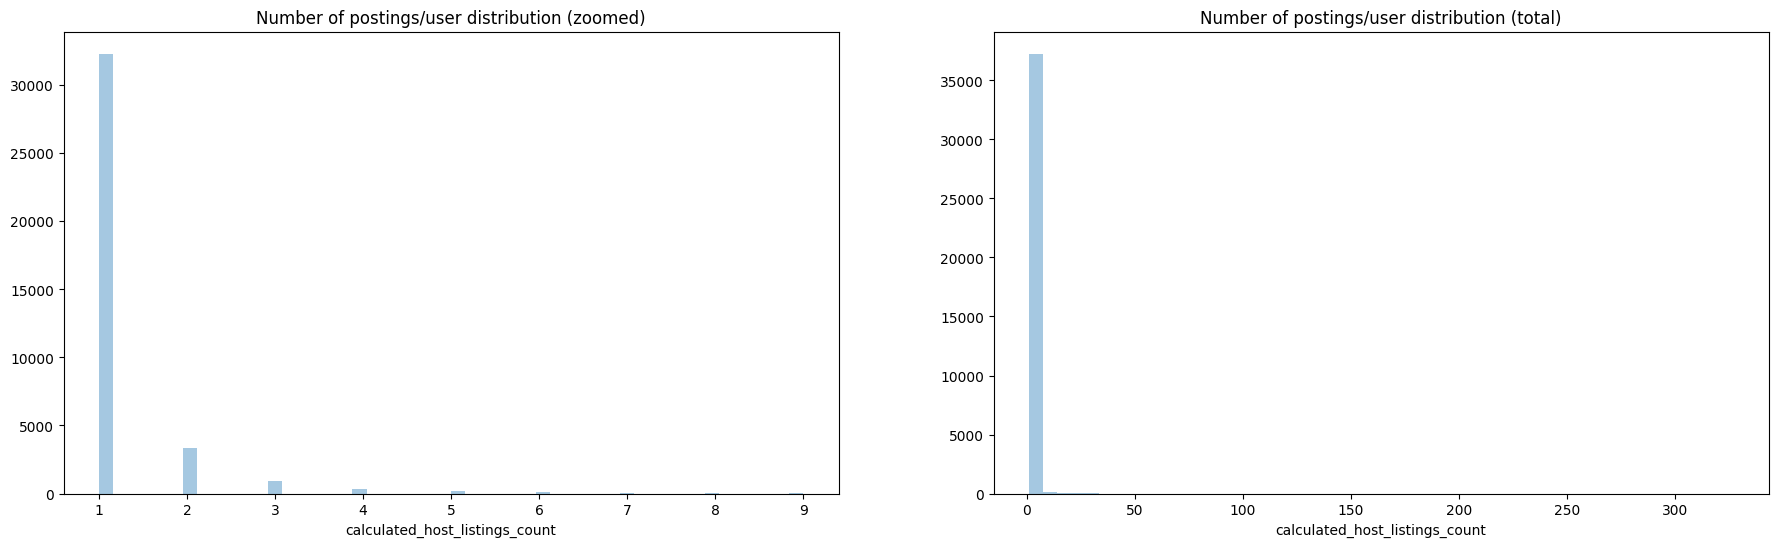

In [23]:
fig, ax = plt.subplots(1,2, figsize=(22,6))
sns.distplot(host_listings_count[host_listings_count < 10], kde=False, hist=True, ax=ax[0])
ax[0].set_title("Number of postings/user distribution (zoomed)")
sns.distplot(host_listings_count, kde=False, hist=True, ax=ax[1])
ax[1].set_title("Number of postings/user distribution (total)")
fig.show()

The distribution plot says us that most users have arround one listing on the platform.

It is surprising that there are some outliers that have >300, maybe they are professional users/agencies. 

To learn more about this, we can define the outliers as the ones who have p postings as p>=μ+2σ

if we consider p the number of postings as the variable of interest:

-The mean μ: the average number of listings per user

-The standard deviation σ: how spread out the number of listings is around the mean

By defining the outliers as users who have a number of listings greater than or equal to μ + 2σ, we are essentially saying that these users have a significantly higher number of listings than what we would expect based on the average and variability of the rest of the dataset.

In [24]:
user_outliers = host_listings_count[host_listings_count >= (summary['mean'] + 2*summary['std'])]
user_outliers

host_id
295128        7.0
310670       13.0
344035       13.0
417504       28.0
732460        7.0
             ... 
263504959     8.0
263880607     7.0
266726110     7.0
270874051     8.0
273354185     7.0
Name: calculated_host_listings_count, Length: 250, dtype: float64

In [25]:
summary

count    37457.000000
mean         1.305363
std          2.760747
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        327.000000
Name: calculated_host_listings_count, dtype: float64

In [26]:
print("Users with most postings")
user_outliers.sort_values().tail(10)

Users with most postings


host_id
1475015       52.0
200380610     65.0
22541573      87.0
61391963      91.0
16098958      96.0
12243051      96.0
137358866    103.0
30283594     121.0
107434423    232.0
219517861    327.0
Name: calculated_host_listings_count, dtype: float64

Let's look for the specific rows of these hosts according to their IDs for further insights

In [27]:
db_subs[db_subs['host_id'] == 219517861].head(1)

id                                           name    host_id   
38293  30181691  Sonder | 180 Water | Incredible 2BR + Rooftop  219517861  \

          host_name neighbourhood_group       neighbourhood  latitude   
38293  Sonder (NYC)           Manhattan  Financial District  40.70637  \

       longitude        room_type  price  minimum_nights  number_of_reviews   
38293  -74.00645  Entire home/apt    302              29                  0  \

      last_review  reviews_per_month  calculated_host_listings_count   
38293         NaN                NaN                             327  \

       availability_365  
38293               309

In [28]:
db_subs[db_subs['host_id'] == 107434423].head(1)

id                                               name    host_id   
26137  20845031  Homey Midtown East 1BR w/ Gym, Doorman, near t...  107434423  \

        host_name neighbourhood_group neighbourhood  latitude  longitude   
26137  Blueground           Manhattan      Kips Bay   40.7451  -73.97915  \

             room_type  price  minimum_nights  number_of_reviews last_review   
26137  Entire home/apt    308              30                  0         NaN  \

       reviews_per_month  calculated_host_listings_count  availability_365  
26137                NaN                             232               156

In [29]:
db_subs[db_subs['host_id'] == 30283594].head(1)

id                                          name   host_id   
9740  7491713  NYC Lavish Studio Apartment Steps from SoHo!  30283594  \

     host_name neighbourhood_group       neighbourhood  latitude  longitude   
9740      Kara           Manhattan  Financial District  40.70862  -74.01408  \

            room_type  price  minimum_nights  number_of_reviews last_review   
9740  Entire home/apt    169              30                  3  2018-12-07  \

      reviews_per_month  calculated_host_listings_count  availability_365  
9740               0.09                             121               364

After conducting a brief search of the usernames, we found evidence to support our hypothesis for the top ranked users, Sonder and Blueground. However, the other users from the third rank onwards appear to be registered as "individual" users despite their high volume of postings, indicating that they may be operating a room rental business. 

We will now examine the postings by professional users to compare them with those of amateur users.

In [30]:
posting_outliers = db_subs[db_subs['host_id'].isin(user_outliers.index.tolist())]
posting_normal = db_subs[~db_subs['host_id'].isin(user_outliers.index.tolist())]

C:\Users\DELL\AppData\Local\Temp\ipykernel_13348\3105688777.py:19: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



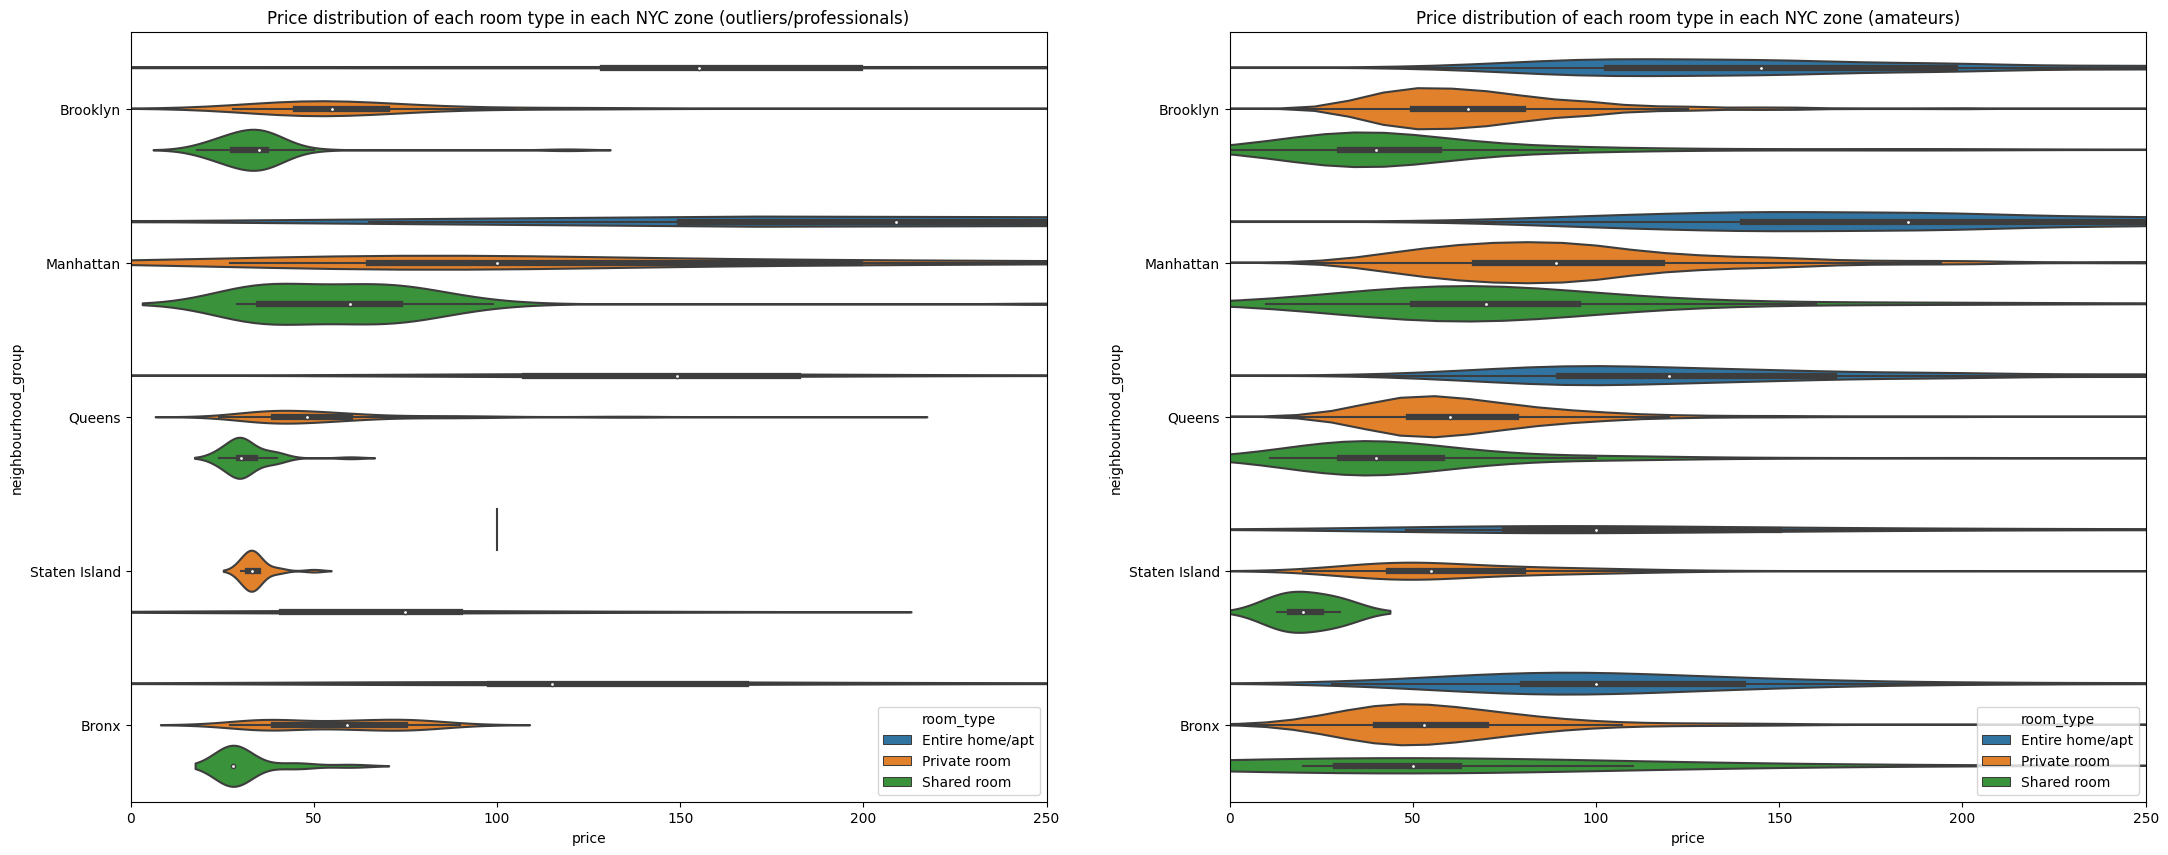

In [31]:
palette ={"Entire home/apt":"C0","Private room":"C1","Shared room":"C2"}

fig, ax = plt.subplots(1,2, figsize=(26,10))

sns.violinplot(x="price", y="neighbourhood_group", hue="room_type", data=posting_outliers, ax=ax[0], 
               palette=palette, 
               order=['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'], 
               hue_order=['Entire home/apt', 'Private room', 'Shared room'])
ax[0].set_title("Price distribution of each room type in each NYC zone (outliers/professionals)")
ax[0].set_xlim(0,250)

sns.violinplot(x="price", y="neighbourhood_group", hue="room_type", data=posting_normal[posting_normal['price'] <= 900], ax=ax[1], 
               palette=palette, 
               order=['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'], 
               hue_order=['Entire home/apt', 'Private room', 'Shared room'])
ax[1].set_title("Price distribution of each room type in each NYC zone (amateurs)")
ax[1].set_xlim(0,250)

fig.show()

It seems that professionals prefer centric/touristic zones (most profitable). Let's represent this preference in a more visual way.

In [32]:
fig = go.Figure()

fig.add_trace(go.Scattermapbox(
        lat=posting_outliers.latitude,
        lon=posting_outliers.longitude,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=5,
            color='rgb(121,181,237)',
            opacity=0.7
        ),name='Professional'
    ))

fig.add_trace(go.Scattermapbox(
        lat=posting_normal.latitude,
        lon=posting_normal.longitude,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=4,
            color='rgb(237,138,121)',
            opacity=0.2
        ), name='Amateur'
    ))

fig.update_layout(
    title='Professional / Amateur postings',
    autosize=True,
    hovermode='closest',
    showlegend=True,
    height=900,
    mapbox=go.layout.Mapbox(
        accesstoken=my_mapbox_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=40.74767,
            lon=-73.97500
        ),
        pitch=0,
        zoom=12,
        style='light'
    ),
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":10})
fig.show()

The professional postings tend to be clustered.

In [33]:
fig = px.scatter_mapbox(posting_outliers[posting_outliers['host_id'].isin(user_outliers.sort_values(ascending=False).head(20).index.tolist())], 
                        lat="latitude", lon="longitude",  color="host_name",
                  color_continuous_scale=cscale, height=760, zoom=12, title='Listings of the top 20 users', range_color=(0,700))

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":10})
fig.show()

Summary: 

In conclusion, the analysis reveals that there are two types of hosts: professional and amateur. Hosts with a greater number of rooms tend to own clustered properties, potentially due to bulk purchasing or renting of apartments/rooms. Professional users tend to post rooms at slightly higher prices than amateur users, and they prefer to list properties in central zones.

##### Room description

This section involves applying light textual analysis techniques to extract additional insights from the data.

In [34]:
# Words that won't add anything apart from what we already know from the other data.
UNWANTED_WORDS = set(['manhattan', 'queen', 'brooklyn', 'nyc'])

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

text = functools.reduce(lambda a,b: a + " " + str(b), db_subs.sample(frac=0.3)['name'])
text = ' '.join([w for w in nltk.word_tokenize(text) if w.lower() not in UNWANTED_WORDS])

wc = wordcloud.WordCloud(max_font_size=40).generate(text)
ax.imshow(wc, interpolation='bilinear')
ax.set_title("Most used words the dataset")
plt.axis("off")

fig.show()

In [ ]:
def get_top_terms(documents, ngram_range=(1,1), unwanted_words=set(), min_occurrences=1):
    """ Get a list of the most common n-grams (sorted)
    Params
    ----------
        documents: List of documents to analyze
        ngram_range (tuple): Whether extracting up to n-grams
        unwanted_words (set): Set of custom blacklist of words
        min_occurrences (int): return only words with occurrences >= min_occurrences
    Returns
    ----------
        List of tuples with (word, n_times).
    """
    blacklist = set(stopwords.words('english')).union(unwanted_words)
    vec = CountVectorizer(stop_words = blacklist, ngram_range=ngram_range)
    sum_words = vec.fit_transform(documents).sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    if min_occurrences > 1:
        words_freq = list(filter(lambda x: x[1] >= min_occurrences, words_freq))
    return words_freq

In [ ]:
top_ngrams = get_top_terms(data.sort_values('reviews_per_month', ascending=False)['name'].iloc[:200], ngram_range=(1,2), unwanted_words=UNWANTED_WORDS, min_occurrences=10)
fig, ax= plt.subplots(5,1,figsize=(25,38))
sns.barplot([x[0] for x in top_ngrams], [x[1] for x in top_ngrams], ax=ax[0],  palette=("Blues_d"))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title('Most common n-grams of the top 200 popular rooms')


top_ngrams = get_top_terms(data.sort_values('price', ascending=False)['name'].iloc[:200], ngram_range=(1,2), unwanted_words=UNWANTED_WORDS, min_occurrences=10)
sns.barplot([x[0] for x in top_ngrams], [x[1] for x in top_ngrams], ax=ax[1],  palette=("Blues_d"))
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title('Most common n-grams of the top 200 expensive rooms')


top_ngrams = get_top_terms(data.sort_values('price', ascending=True)['name'].iloc[:200], ngram_range=(1,2), unwanted_words=UNWANTED_WORDS, min_occurrences=10)
sns.barplot([x[0] for x in top_ngrams], [x[1] for x in top_ngrams], ax=ax[2],  palette=("Blues_d"))
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=40, ha="right")
ax[2].set_title('Most common n-grams of the 200 cheapest rooms')


top_ngrams = get_top_terms(data[data['calculated_host_listings_count']>50]['name'].iloc[:200], ngram_range=(1,2), unwanted_words=UNWANTED_WORDS, min_occurrences=10)
sns.barplot([x[0] for x in top_ngrams], [x[1] for x in top_ngrams], ax=ax[3],  palette=("Blues_d"))
ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=40, ha="right")
ax[3].set_title('Most common n-grams of the top 200 professional rooms')


top_ngrams = get_top_terms(data[data['calculated_host_listings_count']<4]['name'].iloc[:200], ngram_range=(1,2), unwanted_words=UNWANTED_WORDS, min_occurrences=10)
sns.barplot([x[0] for x in top_ngrams], [x[1] for x in top_ngrams], ax=ax[4],  palette=("Blues_d"))
ax[4].set_xticklabels(ax[4].get_xticklabels(), rotation=40, ha="right")
ax[4].set_title('Most common n-grams of the top 200 amateur rooms')


fig.show()

Conclusions: 
Analyzing the distribution of words in different room types reveals interesting differences:

The most expensive rooms tend to be located in central areas, as reflected by the frequent use of words like central, central park, and townhouse. This supports our earlier hypothesis that the location of the room affects its price.
The most popular rooms are often located near airports or just a few minutes away from popular destinations. This suggests that rooms with easy access to transportation are more likely to be popular.
Amateur hosts tend to market their rooms using more subjective terms like "cozy", "spacious", and "great" (focusing on comfort), while professional hosts tend to use more objective language and avoid such terms.
Cheaper rooms are also marketed using subjective language, and there appears to be some overlap between the cheaper rooms and those posted by amateur hosts (as seen in the price distributions above, where amateur rooms tend to be cheaper).

## Data Cleaning

In [38]:
#NaN data in reviews_per_month column
db_subs[db_subs['reviews_per_month'].isna()] = 0

In [39]:
#Removing empty data records
db_subs = db_subs[db_subs['room_type'] != 0]

In [40]:
print(f"Number of data rows after cleaning: {db_subs.count()[0]}")

Number of data rows after cleaning: 38843


In [41]:
#Remove empty prices
db_subs = db_subs[db_subs['price']>0]
#Remove empty strings
db_subs = db_subs[~db_subs['name'].isna()]
#Remove not available rooms
db_subs = db_subs[db_subs['availability_365'] > 0]

#Remove minimum_nights outliers (>95 percentile)
#db_subs = db_subs[db_subs['minimum_nights'] <= 30]

#this code calculates the distances between a set of locations in a DataFrame and three reference locations, and stores the results in new 
# columns of the DataFrame.
db_subs['d_central_park'] = db_subs.apply(lambda r: geodesic((40.782865, -73.964885), (r['latitude'], r['longitude'])).meters, axis=1)
db_subs['d_lga'] = db_subs.apply(lambda r: geodesic((40.772897, -73.873043), (r['latitude'], r['longitude'])).meters, axis=1)
db_subs['d_jfk'] = db_subs.apply(lambda r: geodesic((40.641739, -73.781193), (r['latitude'], r['longitude'])).meters, axis=1)

#Median price in the neighbourhood
median_price_neigh = pd.DataFrame(db_subs.groupby('neighbourhood')['price'].median()) #or mean
#Median price in the neighbourhood group
median_price_neigh_gp = pd.DataFrame(db_subs.groupby('neighbourhood_group')['price'].median()) #or mean
#Avg popularity of rooms in the neighbourhood
median_pop_neigh = pd.DataFrame(db_subs.groupby('neighbourhood')['reviews_per_month'].median()) #or mean
#Number of postings in the neigbourhood
cnt_postings_neigh = pd.DataFrame(db_subs.groupby('neighbourhood')['reviews_per_month'].count()).rename(columns={'reviews_per_month':'postings_in_neighbourhood'})

# Number of postings in the neighbourhood of the same type
d = pd.DataFrame(db_subs.groupby(['neighbourhood', 'room_type'])['room_type'].count())
d.index = d.index.set_names(['neighbourhood', 'r_type'])
d.reset_index(inplace=True)  
d = d.rename(columns={'room_type':'r_type_cnt'})

#Join the new features
db_subs = db_subs.join(median_price_neigh, on='neighbourhood', rsuffix='_median')
db_subs = db_subs.join(median_price_neigh_gp, on='neighbourhood_group', rsuffix='_gp_median')
db_subs = db_subs.join(median_pop_neigh, on='neighbourhood', rsuffix='_median')
db_subs = db_subs.join(cnt_postings_neigh, on='neighbourhood')
db_subs = pd.merge(db_subs, d, how='inner', left_on=['neighbourhood', 'room_type'], right_on=['neighbourhood', 'r_type']).drop(['r_type'], axis=1)


# Check whether name contains "luxury" words
LUXURY_WORDS = ['loft', 'studio', 'townhouse', 'views', 'midtown', 'luxury', 'central', 'park', 'soho', 'village', 'suite', 'west', 'new']
HOT_WORDS = ['iron', 'internet', 'wifi', 'laptop', 'wi-fi', 'family', 'kid', 'private', 'air']
def contains(title, words):
    for w in words:
        if w.lower() in title.lower():
            return True
    return False

db_subs['luxury'] = db_subs.apply(lambda r: contains(r['name'], LUXURY_WORDS), axis=1)
db_subs['hotwords'] = db_subs.apply(lambda r: contains(r['name'], HOT_WORDS), axis=1)


db_subs['price_residual'] = db_subs['price'] - db_subs['price_median']
db_subs['price_residual_percent'] = db_subs['price_residual'] / db_subs['price_median']
db_subs['price_residual_percent'] = db_subs['price_residual_percent'].fillna(0)

# We can also convert some features to log scale in order to make them closer to normal distributed.
db_subs['len_title'] = db_subs.apply(lambda r: len(r['name']), axis=1)


#Get the number of days since a room was reviewed
zero_time_revies = '2019-07-08' #Last day in the dataset will be our t0
db_subs['days_since_last_review'] = (pd.to_datetime(zero_time_revies) - pd.to_datetime(db_subs['last_review'])).apply(lambda i: -1 if pd.isnull(i) else int(i.days))


Correlation check

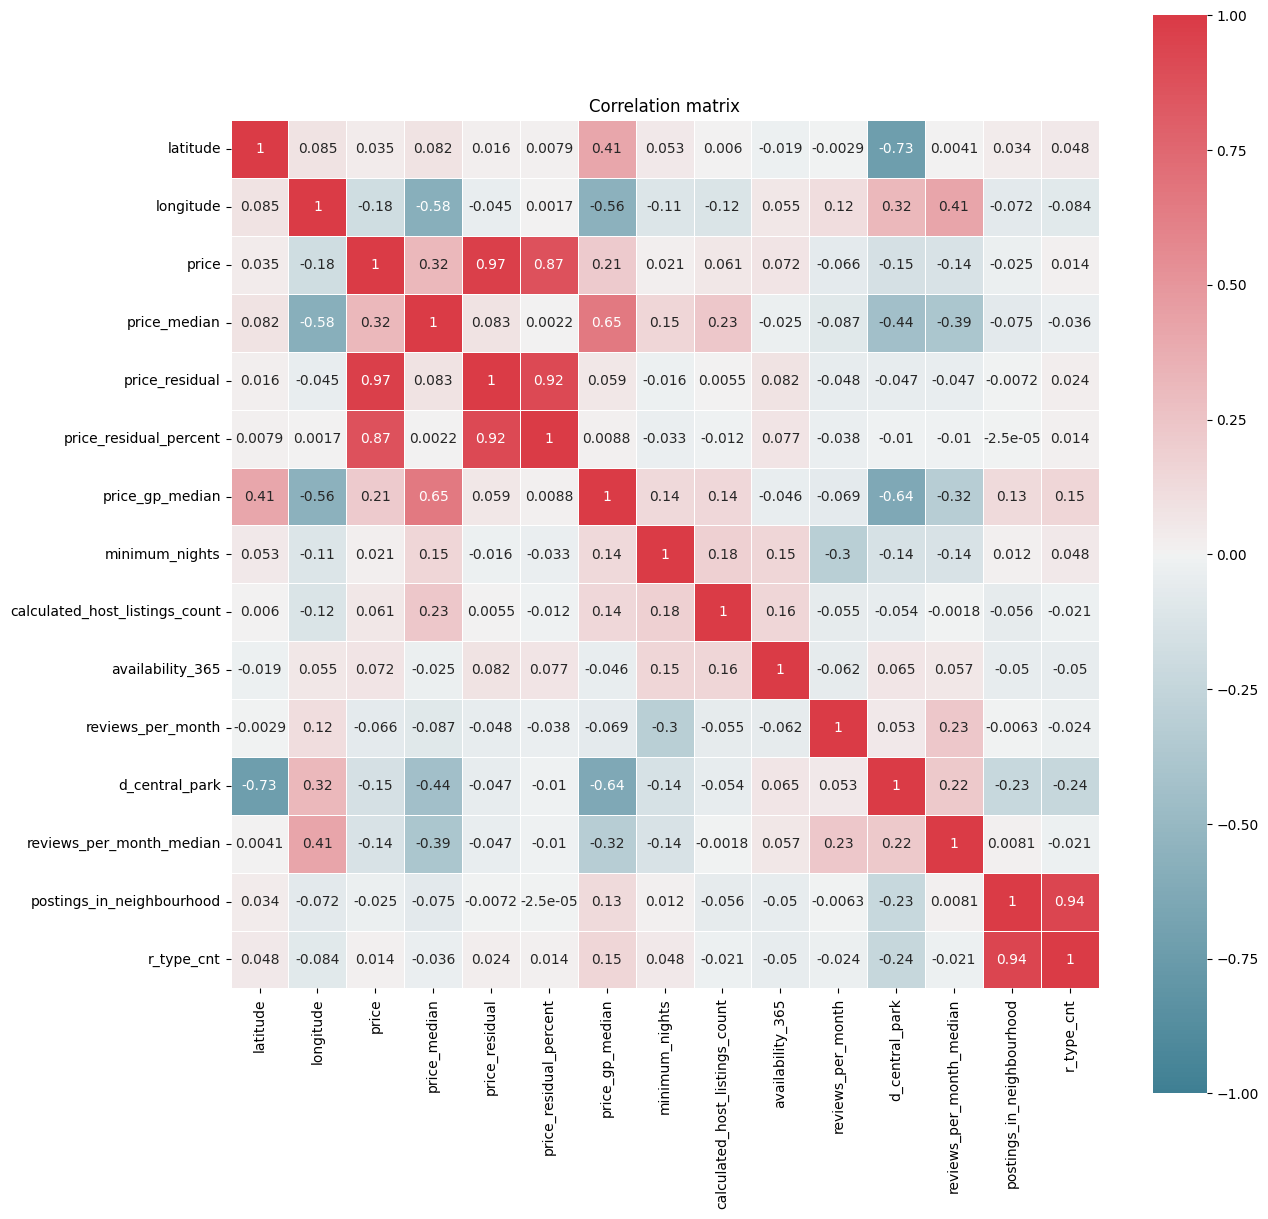

In [42]:
corr = db_subs[['latitude', 'longitude', 'price', 'price_median', 'price_residual', 'price_residual_percent', 'price_gp_median','minimum_nights', 'calculated_host_listings_count', 'availability_365', 'reviews_per_month', 'd_central_park', 'reviews_per_month_median', 
                                   'postings_in_neighbourhood', 'r_type_cnt']].corr(method='pearson')
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(corr, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            center=0, vmin=-1, vmax=1, 
            square=True,
            annot=True,
            linewidths=.5,
            ax = ax)
_ = ax.set_title('Correlation matrix')

## Modeling

        Simple Linear Regression

In [43]:
data_linear = db_subs.copy()

In [44]:
oh_rooom_type = pd.get_dummies(data_linear['room_type'])
#oh_neighbourhood = pd.get_dummies(data_linear['neighbourhood'])
oh_neighbourhood_group = pd.get_dummies(data_linear['neighbourhood_group'])

oh_features = pd.concat([oh_rooom_type], axis=1)

data_linear = pd.concat([data_linear,oh_features], axis=1)

In [45]:
predictors, target = data_linear[[
 'minimum_nights',
 'availability_365',
 'price_median',
 'reviews_per_month_median',
 'luxury',
 'hotwords',
 'len_title']],\
                     data_linear['reviews_per_month']

X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.33, random_state=42)

In [46]:


reg = LinearRegression().fit(X_train, y_train)



In [47]:
eli5.explain_weights(reg, feature_names=predictors.columns.tolist())

Explanation(estimator='LinearRegression()', description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='reviews_per_month_median', weight=0.8167469361653255, std=None, value=None), FeatureWeight(feature='<BIAS>', weight=0.42602447921402775, std=None, value=None), FeatureWeight(feature='hotwords', weight=0.17808563317359416, std=None, value=None), FeatureWeight(feature='luxury', weight=0.11975859140068211, std=None, value=None), FeatureWeight(feature='len_title', weight=0.013679682695855871, std=None, value=None), FeatureWeight(feature='price_median', weight=0.0009921251638705098, std=None, value=None)], neg=[FeatureWeight(feature='minimum_nights', weight=-0.06214907351436203, std=None, value=None), FeatureWeight(feature='availability_365', weight=-0.0002932618972019225, std=None, value=None)], pos_remaining=0, neg_remaining=0), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [48]:
res = reg.predict(X_test)
y_test2 = y_test.values

MSE: 2.707630900670016
MAE: 1.2254882807031435
R2: 0.14249309565832546


C:\Users\DELL\AppData\Local\Temp\ipykernel_13348\3329630863.py:12: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\DELL\AppData\Local\Temp\ipykernel_13348\3329630863.py:13: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




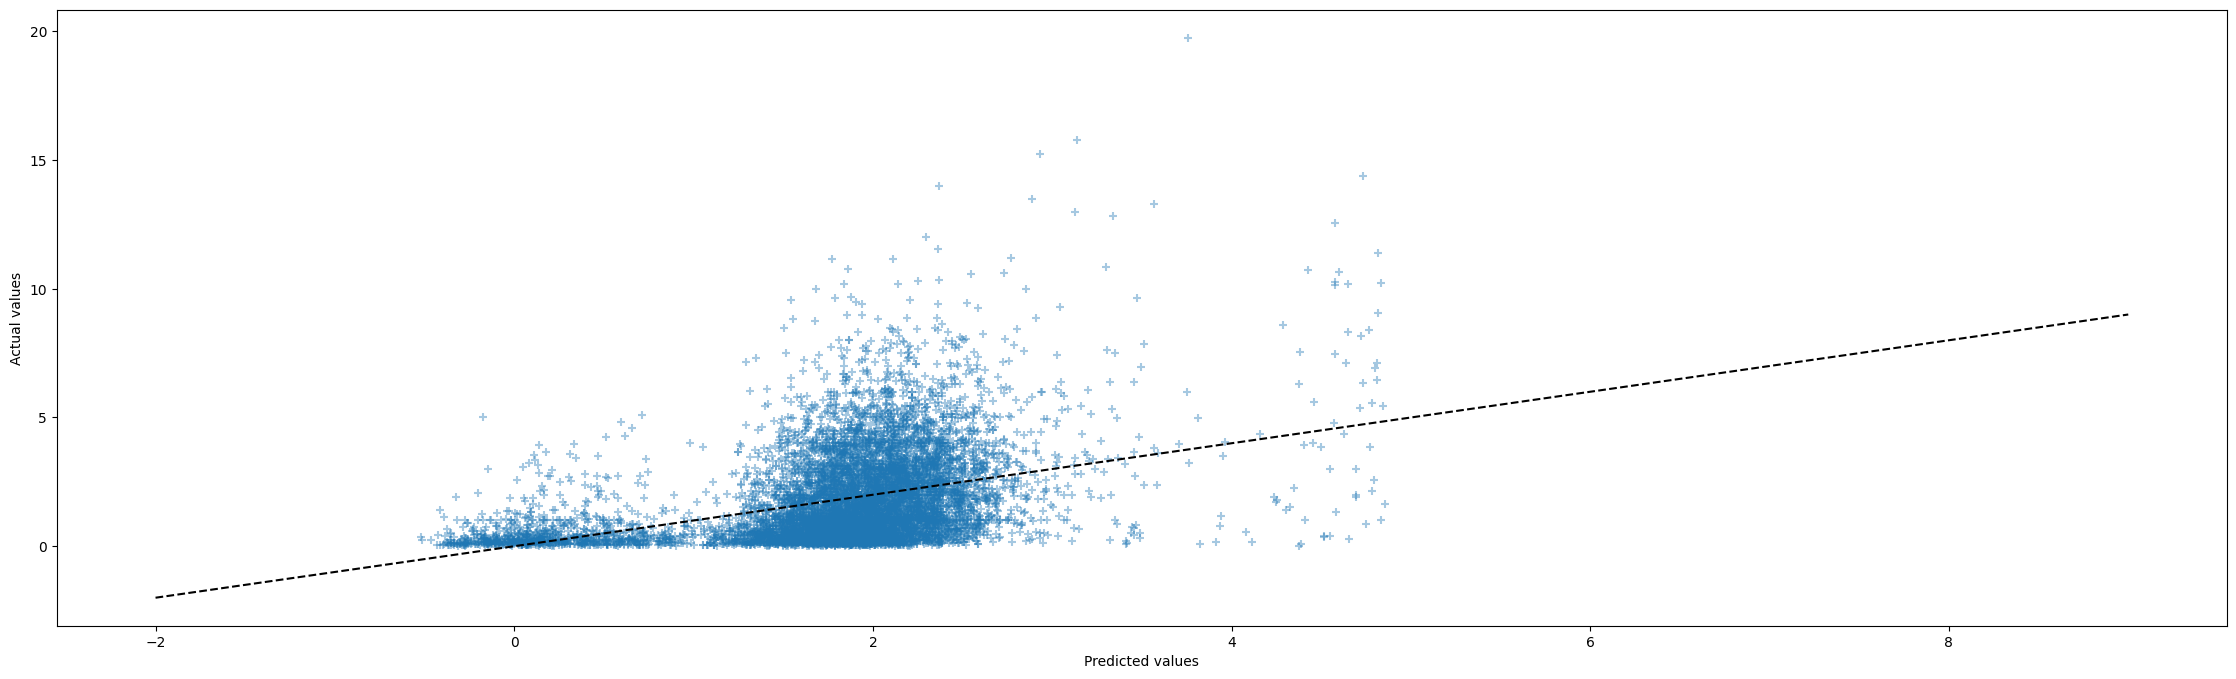

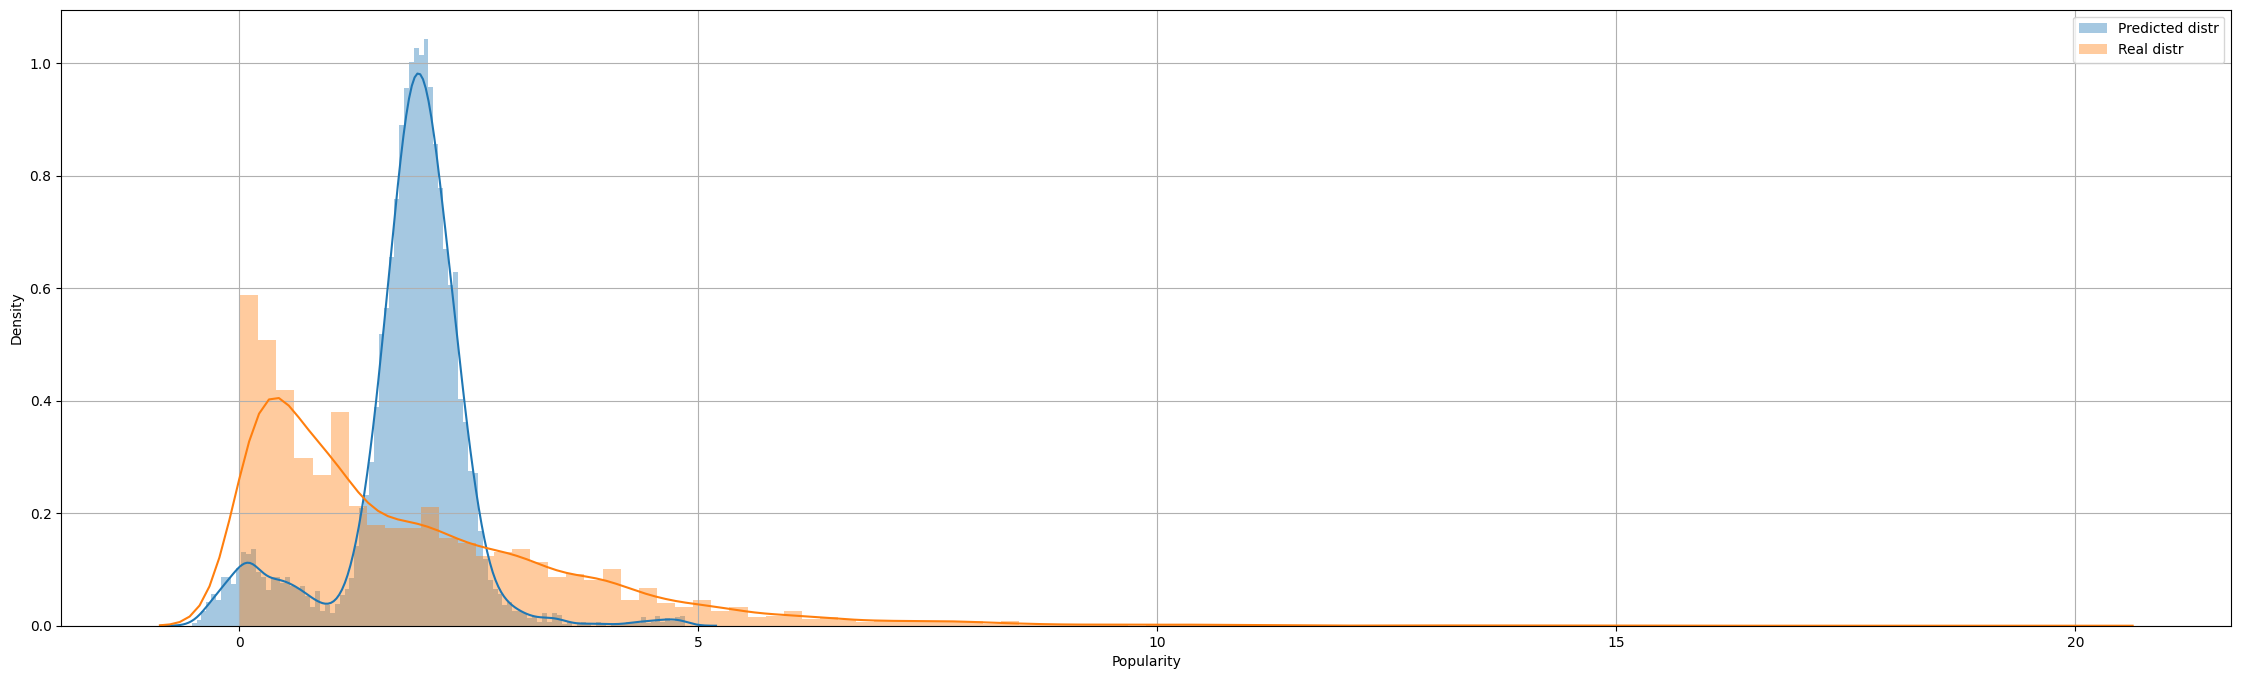

In [49]:
print(f"MSE: {mean_squared_error(y_test2, res)}")
print(f"MAE: {mean_absolute_error(y_test2, res)}")
print(f"R2: {r2_score(y_test2, res)}")

fig, ax= plt.subplots(1, figsize=(28,8))
ax.scatter(res, y_test2, alpha=0.4, marker='+')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
ax.plot(list(range(-2,10)), list(range(-2,10)), color='black', linestyle='--')

fig, ax= plt.subplots(1, figsize=(28,8))
sns.distplot(res, ax=ax, label='Predicted distr', bins=100)
sns.distplot(y_test2, ax=ax, label='Real distr', bins=100)
ax.set_xlabel("Popularity")
ax.legend()
ax.grid(True)

Based on the analysis, it is evident that the model does not fit the original data distribution very well. To improve the accuracy, a more complex model is required, and therefore, we recommend using ensembles such as boosted trees to enhance the performance of the model.

        Tree Boosting (XGB)

In [52]:
enc_neigh = LabelEncoder() 
enc_neigh_gp = LabelEncoder()
enc_rtype = LabelEncoder()

db_subs['enc_neighbourhood'] = enc_neigh.fit_transform(db_subs['neighbourhood'])
db_subs['enc_room_type'] = enc_rtype.fit_transform(db_subs['room_type'])
db_subs['enc_neighbourhood_gp'] = enc_neigh_gp.fit_transform(db_subs['neighbourhood_group'])

In [53]:
db_subs.columns.tolist()

['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'd_central_park',
 'd_lga',
 'd_jfk',
 'price_median',
 'price_gp_median',
 'reviews_per_month_median',
 'postings_in_neighbourhood',
 'r_type_cnt',
 'luxury',
 'hotwords',
 'price_residual',
 'price_residual_percent',
 'len_title',
 'days_since_last_review',
 'enc_neighbourhood',
 'enc_room_type',
 'enc_neighbourhood_gp']

In [54]:
predictors, target = db_subs[[
 'latitude',
 'longitude',
 'price',
 'minimum_nights',
 'calculated_host_listings_count',
 'availability_365',
 'd_central_park',
 'd_lga',
 'd_jfk',
 'price_median',
 'price_gp_median',
 'reviews_per_month_median',
 'postings_in_neighbourhood',
 'r_type_cnt',
 'luxury',
 'hotwords',
 'price_residual',
 'price_residual_percent',
 'len_title',
 'days_since_last_review',
 'enc_neighbourhood',
 'enc_room_type',
 'enc_neighbourhood_gp']],\
                     db_subs['reviews_per_month']

X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.33, random_state=42)

In [55]:
param = {
    "objective": "reg:squarederror",
    "nthread":4,
    'n_estimators': 2000,
}

xgb_model = xgb.XGBRegressor(**param)

MSE: 1.7882197479763804
MAE: 0.9249730412226417
R2: 0.433670674983645


C:\Users\DELL\AppData\Local\Temp\ipykernel_13348\3581195528.py:16: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\DELL\AppData\Local\Temp\ipykernel_13348\3581195528.py:17: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




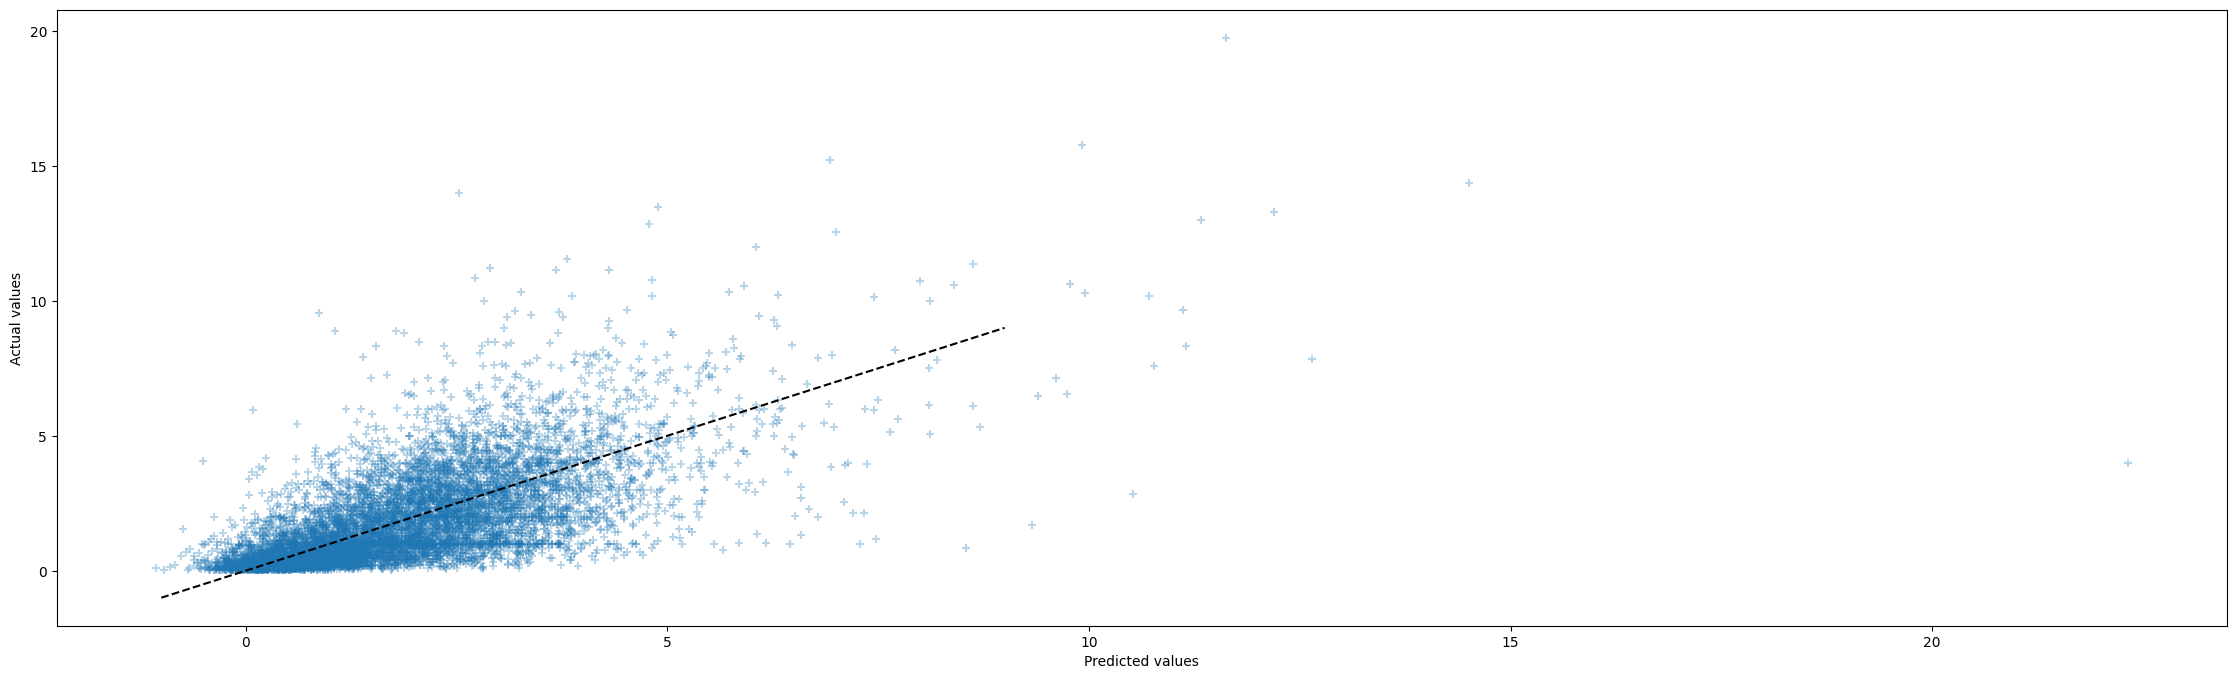

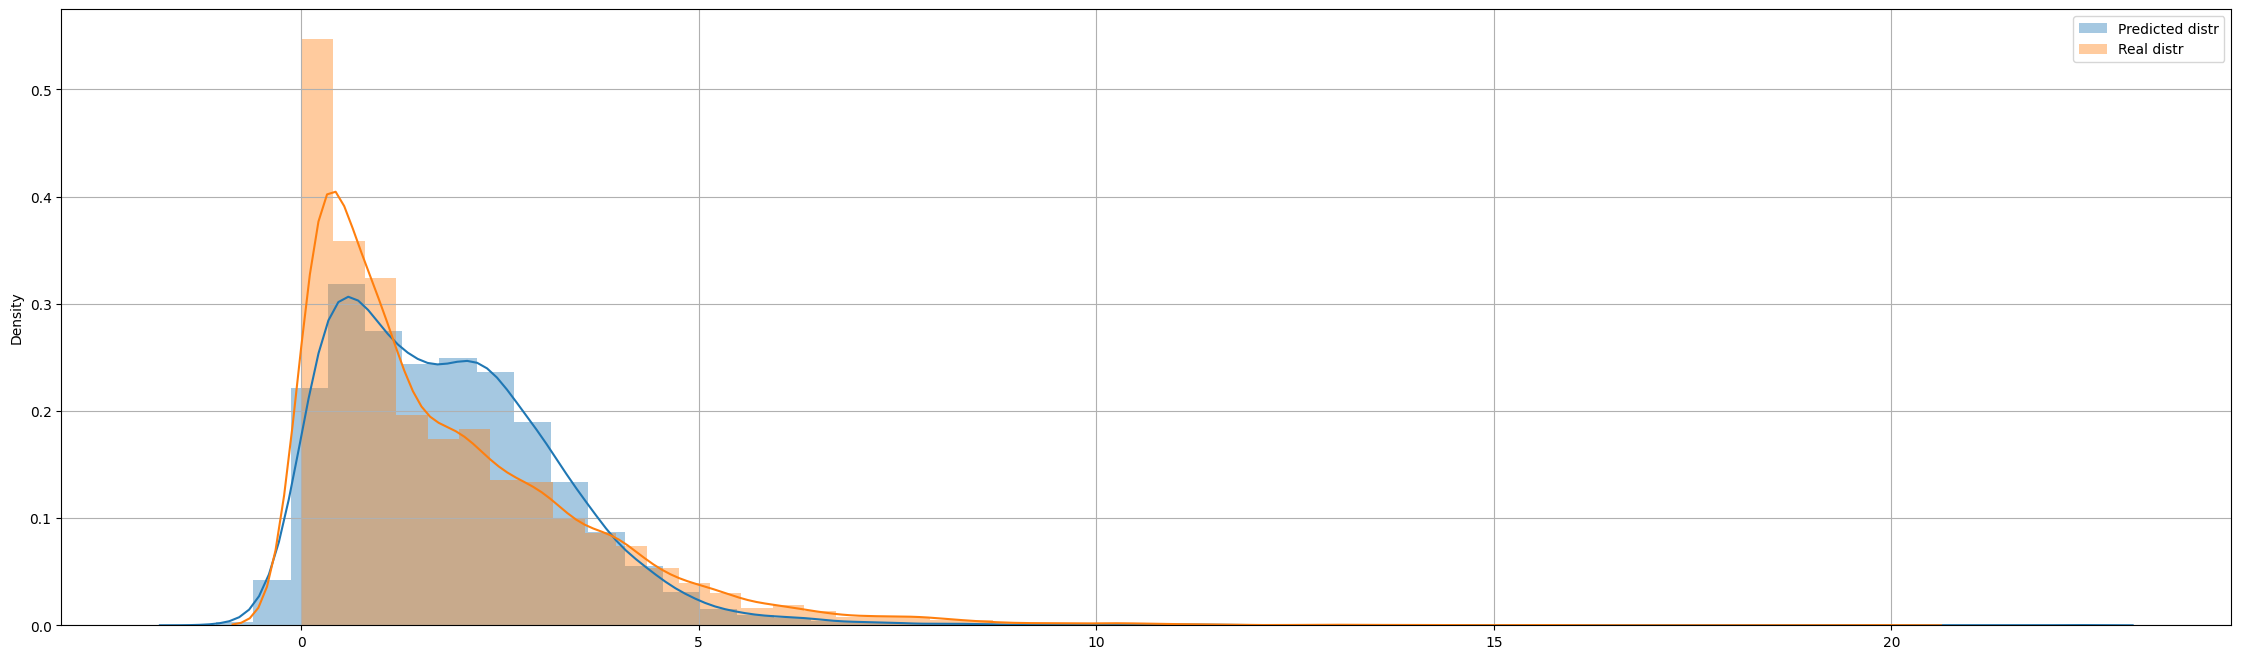

In [56]:
xgb_model.fit(X_train, y_train)

res = xgb_model.predict(X_test)

print(f"MSE: {mean_squared_error(y_test, res)}")
print(f"MAE: {mean_absolute_error(y_test, res)}")
print(f"R2: {r2_score(y_test, res)}")

fig, ax= plt.subplots(1, figsize=(28,8))
ax.scatter(res, y_test.values, alpha=0.3, marker='+')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
ax.plot(list(range(-1,10)), list(range(-1,10)), color='black', linestyle='--')

fig, ax= plt.subplots(1, figsize=(28,8))
sns.distplot(res, ax=ax, label='Predicted distr')
sns.distplot(y_test.values, ax=ax, label='Real distr')
ax.legend()
ax.grid(True)

In [57]:
eli5.explain_weights(xgb_model)

Explanation(estimator='XGBRegressor(base_score=None, booster=None, callbacks=None,\n             colsample_bylevel=None, colsample_bynode=None,\n             colsample_bytree=None, early_stopping_rounds=None,\n             enable_categorical=False, eval_metric=None, feature_types=None,\n             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n             interaction_constraints=None, learning_rate=None, max_bin=None,\n             max_cat_threshold=None, max_cat_to_onehot=None,\n             max_delta_step=None, max_depth=None, max_leaves=None,\n             min_child_weight=None, missing=nan, monotone_constraints=None,\n             n_estimators=2000, n_jobs=None, nthread=4, num_parallel_tree=None,\n             predictor=None, ...)', description='\nXGBoost feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=True, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='days_since_last_review', weight=0.20259121, std=None, value=None), FeatureWeight(feature='minimum_nights', weight=0.12229983, std=None, value=None), FeatureWeight(feature='reviews_per_month_median', weight=0.102066234, std=None, value=None), FeatureWeight(feature='enc_room_type', weight=0.060230426, std=None, value=None), FeatureWeight(feature='calculated_host_listings_count', weight=0.050625898, std=None, value=None), FeatureWeight(feature='enc_neighbourhood_gp', weight=0.03682458, std=None, value=None), FeatureWeight(feature='price_gp_median', weight=0.036188375, std=None, value=None), FeatureWeight(feature='d_jfk', weight=0.028821483, std=None, value=None), FeatureWeight(feature='price_residual', weight=0.028392175, std=None, value=None), FeatureWeight(feature='availability_365', weight=0.0272282, std=None, value=None), FeatureWeight(feature='enc_neighbourhood', weight=0.02660586, std=None, value=None), FeatureWeight(feature='r_type_cnt', weight=0.026487889, std=None, value=None), FeatureWeight(feature='price_median', weight=0.026475938, std=None, value=None), FeatureWeight(feature='d_lga', weight=0.026158862, std=None, value=None), FeatureWeight(feature='luxury', weight=0.025139058, std=None, value=None), FeatureWeight(feature='hotwords', weight=0.024933284, std=None, value=None), FeatureWeight(feature='d_central_park', weight=0.024916174, std=None, value=None), FeatureWeight(feature='price_residual_percent', weight=0.024698138, std=None, value=None), FeatureWeight(feature='len_title', weight=0.022297898, std=None, value=None), FeatureWeight(feature='longitude', weight=0.022229569, std=None, value=None)], remaining=3), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

After analyzing the variables, we observed that the top 2 features have the most impact on the decision-making process. Nevertheless, we decided to use 7 features as it appears to be a reasonable number to work with. Although the price and popularity seem to have a weak relationship, we previously found that more expensive postings usually receive fewer visitors. Therefore, we decided to include the 7th feature.

In [58]:
most_interesting_features = eli5.explain_weights_df(xgb_model).iloc[:7, 0].tolist()
most_interesting_features

['days_since_last_review',
 'minimum_nights',
 'reviews_per_month_median',
 'enc_room_type',
 'calculated_host_listings_count',
 'enc_neighbourhood_gp',
 'price_gp_median']

        -> Model Tuning

We perform a randomized search on a grid with cross-validation of 5 folds to find an optimal setup for the hyperparameters.

In [59]:
predictors, target = db_subs[most_interesting_features],\
                     db_subs['reviews_per_month']

X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.33, random_state=42)

In [60]:
grid = {
        'max_depth': [5, 7, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 7, 10, 12],
        'n_estimators': [1200, 1700, 2000, 2500]
        }

In [61]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror")

In [62]:
# We will sample only 6 locations in the search space
random_search = RandomizedSearchCV(xgb_model, param_distributions=grid, n_iter=6, scoring='r2', n_jobs=4, cv=5,verbose=3, random_state=1001) 

In [63]:


random_search.fit(X_train, y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=6, n_jobs=4,
                   param_distributions={'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5, 7, 10, 12],
                                        'n_estimators': [1200, 1700, 2000,
                                                         2500],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1001, scoring='r2', verbose=3)

In [64]:
results = pd.DataFrame(random_search.cv_results_).sort_values('rank_test_score')
results

mean_fit_time  std_fit_time  mean_score_time  std_score_time   
1      25.077970      0.587191         0.024136        0.009902  \
3      32.951480      1.594010         0.019749        0.001323   
5       5.760594      0.400871         0.034508        0.006004   
0      18.861512      0.166553         0.135039        0.011607   
4      34.263172      1.810230         0.194883        0.027324   
2      40.267351      1.123385         0.337697        0.066914   

  param_subsample param_n_estimators param_max_depth param_gamma   
1             1.0               2500               7           5  \
3             1.0               2000              12           2   
5             0.8               1200               3         1.5   
0             0.6               2000               5           2   
4             0.6               1700              10           2   
2             0.8               2000              10         0.5   

                                              params  split0_test_score   
1  {'subsample': 1.0, 'n_estimators': 2500, 'max_...           0.456445  \
3  {'subsample': 1.0, 'n_estimators': 2000, 'max_...           0.398580   
5  {'subsample': 0.8, 'n_estimators': 1200, 'max_...           0.435461   
0  {'subsample': 0.6, 'n_estimators': 2000, 'max_...           0.228744   
4  {'subsample': 0.6, 'n_estimators': 1700, 'max_...           0.082819   
2  {'subsample': 0.8, 'n_estimators': 2000, 'max_...           0.122370   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score   
1           0.408551           0.239483           0.479836           0.375010  \
3           0.337921           0.283441           0.451579           0.296976   
5           0.373449           0.081263           0.465062           0.404771   
0           0.193668           0.191366           0.360979          -0.125535   
4           0.002714          -0.052132           0.232086          -0.003184   
2          -0.114267          -0.051690           0.207213          -0.090663   

   mean_test_score  std_test_score  rank_test_score  
1         0.391865        0.084489                1  
3         0.353699        0.063241                2  
5         0.352001        0.138775                3  
0         0.169844        0.160176                4  
4         0.052461        0.099697                5  
2         0.014593        0.127118                6

In [65]:
results.iloc[0]['params']

{'subsample': 1.0, 'n_estimators': 2500, 'max_depth': 7, 'gamma': 5}

In [66]:
print(f'R2 (Train):{results.iloc[0]["mean_test_score"]}')

R2 (Train):0.39186490253336126


        -> Model testing

In [67]:
bst = random_search.best_estimator_
res = bst.predict(X_test)

MSE: 1.7721160834649863
MAE: 0.8816851618047332
R2: 0.4387707067126023


C:\Users\DELL\AppData\Local\Temp\ipykernel_13348\2945102556.py:12: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\DELL\AppData\Local\Temp\ipykernel_13348\2945102556.py:13: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




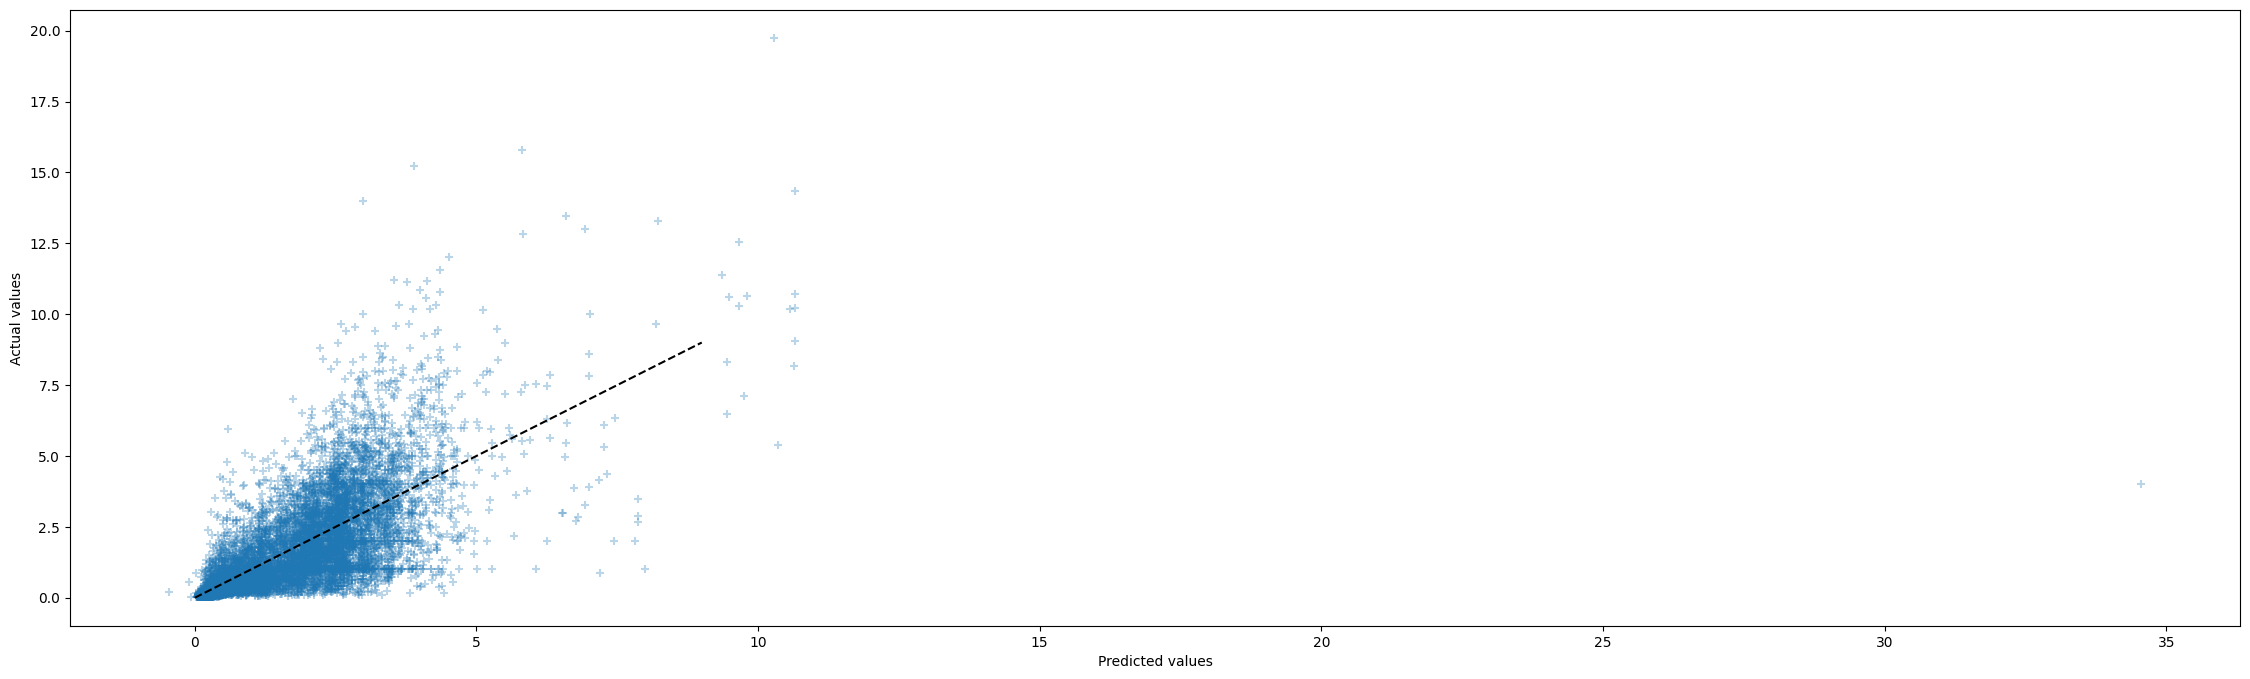

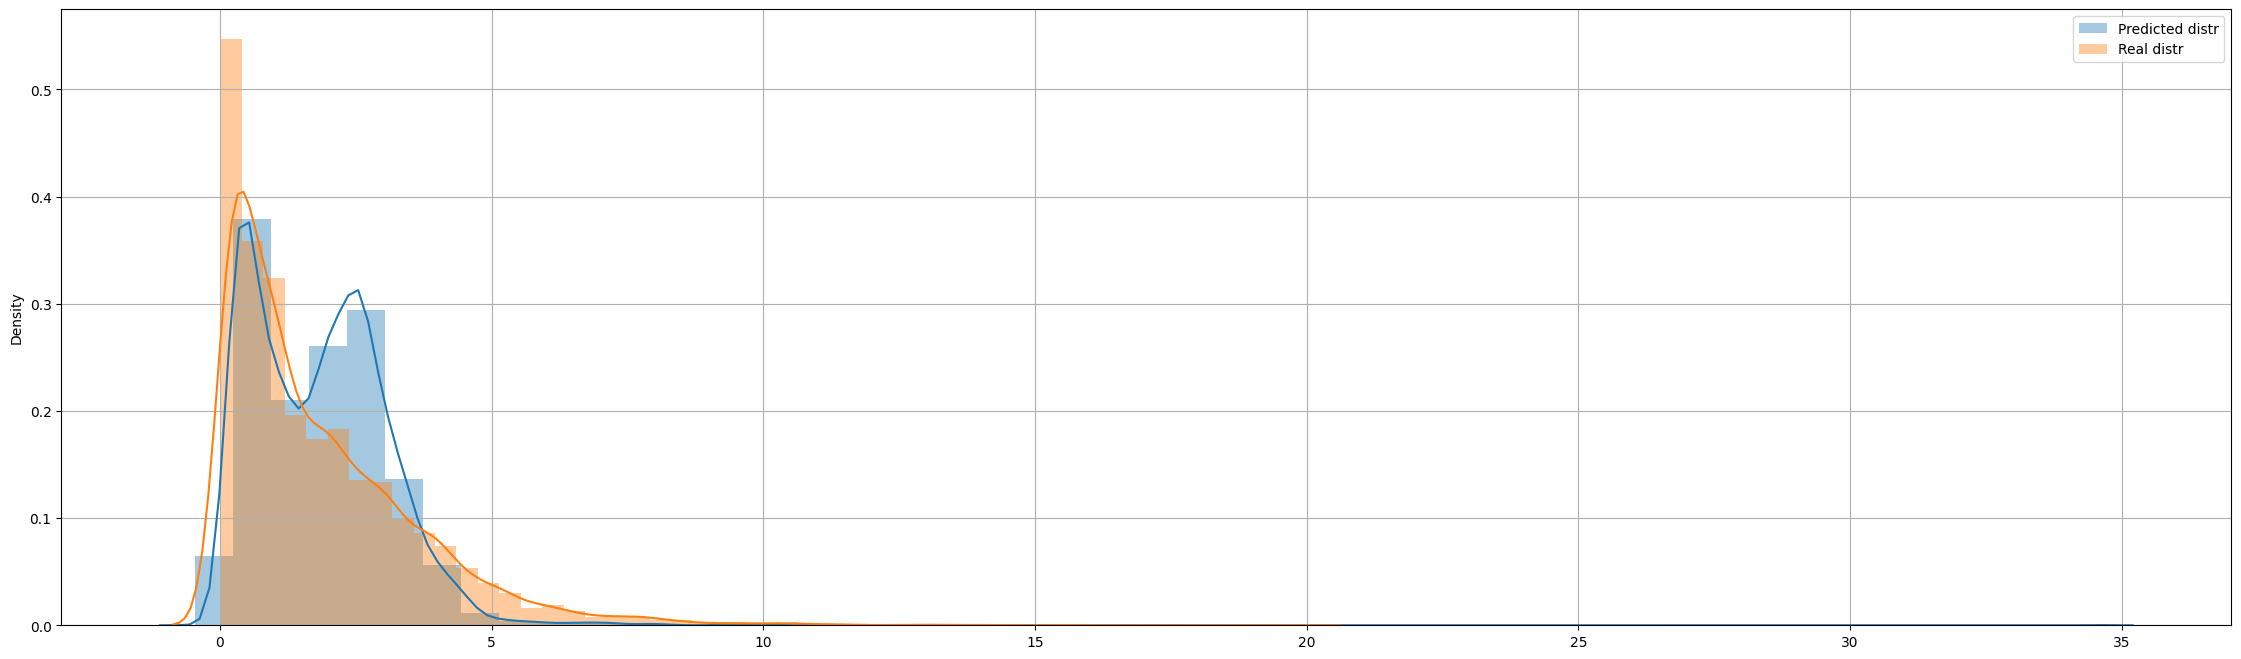

In [68]:
print(f"MSE: {mean_squared_error(y_test, res)}")
print(f"MAE: {mean_absolute_error(y_test, res)}")
print(f"R2: {r2_score(y_test, res)}")

fig, ax= plt.subplots(1, figsize=(28,8))
ax.scatter(res, y_test.values, alpha=0.3, marker='+')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
ax.plot(list(range(0,10)), list(range(0,10)), color='black', linestyle='--')

fig, ax= plt.subplots(1, figsize=(28,8))
sns.distplot(res, ax=ax, label='Predicted distr')
sns.distplot(y_test.values, ax=ax, label='Real distr')
ax.legend()
ax.grid(True)

<bound method Figure.show of <Figure size 1600x800 with 1 Axes>>

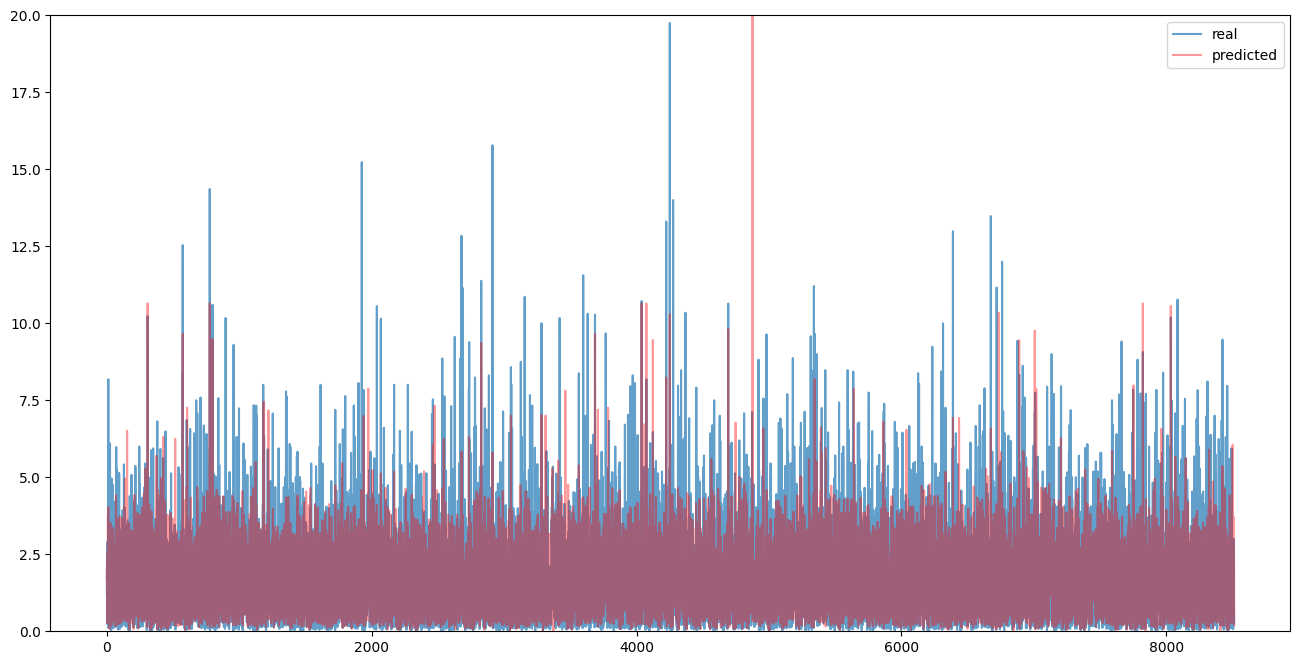

In [69]:


fig = plt.figure(figsize=(16,8))
plt.plot(y_test.values, label='real', alpha=0.7)
plt.plot(res, label='predicted', alpha=0.4, color='red')
plt.ylim((0,20))
plt.legend()
fig.show



## Modeling Summary

We have found that the Tree Boosting method is a promising approach for this task. However, it should be noted that the model is not able to explain a very high percentage of the variance in the data. This could indicate that additional feature engineering may be necessary, or that the popularity of an Airbnb listing cannot be accurately determined with the available data alone. For example, factors such as the quality of the room photos, guest comments and ratings, description of the posting, or information about the room owner's profile could also play an important role in determining whether a listing is booked or not, but this information is not available in this dataset.